# Proyek System Recommendation: [Book Recommendation System]
- **Nama:** I Dewa Gede Mahesta Parawangsa
- **Email:** dewamahesta2711@gmail.com
- **ID Dicoding:** demahesta

## Import Library

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import difflib
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

### Data Loading

In [2]:
file_name = 'book.xlsx'

try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"File '{file_name}' not found. Make sure it's uploaded.")
except Exception as e:
    print(f"Incorrect file format or error: {e}")
else:
    print("Data loaded successfully:")

Data loaded successfully:


Pada Proses ini Mencoba **membaca file Excel** (`book.xlsx`) ke dalam DataFrame `df` sambil **menangani potensi error** yang mungkin terjadi selama proses pembacaan.
*   **Alur Proses:**
    1.  **Percobaan (`try`):** Kode pertama-tama *mencoba* menjalankan perintah `pd.read_excel(file_name)` untuk memuat data dari file Excel.
    2.  **Penanganan Error: File Tidak Ditemukan (`except FileNotFoundError`):** Jika percobaan gagal karena file `book.xlsx` **tidak ditemukan** di lokasi yang diharapkan, maka kode di dalam blok `except FileNotFoundError` akan dijalankan (mencetak pesan file tidak ditemukan).
    3.  **Penanganan Error: Lainnya (`except Exception`):** Jika percobaan gagal karena **error lain** (misalnya, file bukan format Excel yang valid, file rusak, masalah izin baca), maka kode di dalam blok `except Exception` akan dijalankan (mencetak pesan error yang lebih umum beserta detail errornya).
    4.  **Jika Sukses (`else`):** Jika percobaan dalam blok `try` **berhasil** tanpa menimbulkan error apapun, maka kode di dalam blok `else` akan dijalankan (mencetak pesan bahwa data berhasil dimuat).

## Data Understanding

In [3]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780000000000,2005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,385.0,247.0,361.0
1,9780000000000,2261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,383.0,241.0,5164.0
2,9780010000000,6163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,397.0,479.0,172.0
3,9780010000000,6178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,393.0,512.0,29532.0
4,9780010000000,6280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,415.0,170.0,33684.0


Menampilkan **beberapa baris pertama** (secara default 5 baris) dari DataFrame `df`.
*   **Kegunaan:** Umumnya digunakan untuk **verifikasi cepat** setelah memuat data, guna memastikan data terlihat benar dan untuk melihat **nama kolom** serta **contoh nilai** di awal dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6547 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


#### Penjelasan Fitur (Kolom) dalam Output:

Kode ini menampilkan informasi kolom pada dataset. Berdasarkan output `df.info()`, berikut penjelasan untuk masing-masing kolom (fitur) dalam dataset buku Anda:

*   **isbn13:** Nomor ISBN (International Standard Book Number) 13 digit. Pengenal unik global untuk buku. Dilihat dari `int64`, ini disimpan sebagai angka bulat.
*   **isbn10:** Nomor ISBN 10 digit (versi lama). Pengenal unik lainnya untuk buku. Disimpan sebagai `object` (kemungkinan karena bisa mengandung huruf 'X' atau perlu mempertahankan format spesifik).
*   **title:** Judul utama buku. Disimpan sebagai `object` (teks/string).
*   **subtitle:** Subjudul atau judul tambahan buku. Banyak nilai kosong (`2381 non-null` dari `6810` entri), menunjukkan tidak semua buku memiliki subjudul. Disimpan sebagai `object`.
*   **authors:** Nama penulis atau para penulis buku. Ada beberapa nilai kosong. Disimpan sebagai `object`.
*   **categories:** Genre atau kategori buku (misalnya, Fiksi, Komputer, Sejarah). Ada beberapa nilai kosong. Disimpan sebagai `object`.
*   **thumbnail:** Kemungkinan berisi URL atau path ke gambar sampul kecil (thumbnail) buku. Ada beberapa nilai kosong. Disimpan sebagai `object`.
*   **description:** Deskripsi atau sinopsis singkat tentang isi buku. Ada beberapa nilai kosong. Disimpan sebagai `object`.
*   **published\_year:** Tahun buku tersebut diterbitkan. Disimpan sebagai `float64` (angka desimal), mungkin karena ada nilai kosong yang direpresentasikan sebagai NaN (Not a Number) yang lebih cocok dengan float, atau mungkin ada kesalahan input. Ada beberapa nilai kosong.
*   **average\_rating:** Rata-rata peringkat atau rating yang diberikan pengguna untuk buku tersebut (misalnya, dalam skala 1-5). Disimpan sebagai `float64`. Ada beberapa nilai kosong.
*   **num\_pages:** Jumlah halaman dalam buku. Disimpan sebagai `float64`. Ada beberapa nilai kosong.
*   **ratings\_count:** Jumlah total penilaian atau ulasan yang telah diterima buku. Disimpan sebagai `float64`. Ada beberapa nilai kosong.

In [ ]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the table.')

There are 6810 rows and 12 columns in the table.


Kode ini Mencetak jumlah baris dan kolom dalam DataFrame `df`.
*   **Cara Kerja:** Mengambil jumlah baris (`df.shape[0]`) dan jumlah kolom (`df.shape[1]`) lalu menampilkannya dalam sebuah kalimat.
*   **Hasil:** Output `There are 6810 rows and 12 columns in the table.` menunjukkan DataFrame memiliki 6810 baris dan 12 kolom.

In [ ]:
df.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count'],
      dtype='object')

*   **Tujuan Utama:** Menampilkan **daftar nama** dari semua **kolom** yang ada dalam DataFrame `df`.
*   **Output:** Hasilnya adalah objek `Index` yang berisi nama-nama kolom tersebut.

In [ ]:
df.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,354.418354,348.181026,2.106910e+04
std,6.067872e+08,10.484257,116.563100,242.376783,1.376207e+05
min,9.780000e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,367.000000,208.000000,1.590000e+02
50%,9.780550e+12,2002.000000,392.000000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,412.000000,420.000000,5.992500e+03
max,9.789040e+12,2019.000000,491.000000,3342.000000,5.629932e+06


Berikut ringkasan informasi mengenai struktur dan tipe data dalam dataset book.xlsx:

*   Dataset ini memiliki **6810 sampel** (baris data atau entri buku).
*   Terdapat **12 fitur** (kolom) dalam dataset yang mendeskripsikan setiap buku.
*   Dataset terdiri dari **4 fitur** dengan tipe data `float64`, **1 fitur** dengan tipe data `int64`, dan **7 fitur** dengan tipe data `object` (umumnya teks/string).
*   Dataset ini berasal dari file berformat CSV (Comma-Separated Values).

### Eksploratory Data Analysis

<ipython-input-5-e0821a4be810>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories.values, y=categories.index, palette='viridis')


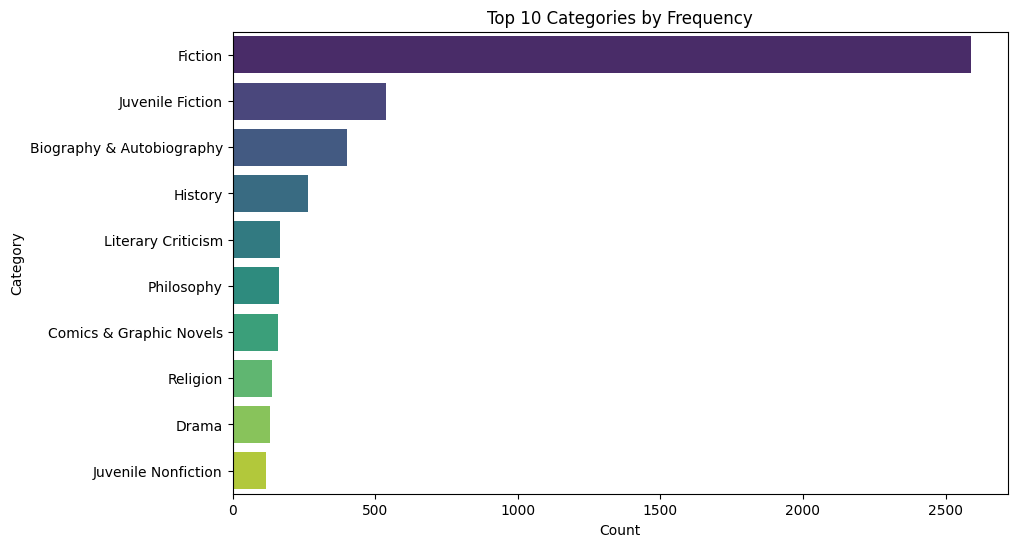


Top 10 Categories by Frequency (Detailed Data):
                 Category  Count
                  Fiction   2588
         Juvenile Fiction    538
Biography & Autobiography    401
                  History    266
       Literary Criticism    166
               Philosophy    162
  Comics & Graphic Novels    159
                 Religion    137
                    Drama    132
      Juvenile Nonfiction    116


In [5]:
# Category Distribution
categories = df['categories'].str.split(',').explode().str.strip().value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=categories.values, y=categories.index, palette='viridis')
plt.title('Top 10 Categories by Frequency')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Print detailed category data
categories_df = categories.reset_index()
categories_df.columns = ['Category', 'Count']
print("\nTop 10 Categories by Frequency (Detailed Data):")
print(categories_df.to_string(index=False))

Interpretasi EDA: Top 10 Kategori Buku Paling Umum

Analisis ini (digambarkan dalam *bar chart* dan tabel data) menunjukkan **10 kategori buku yang paling sering muncul** dalam dataset:

*   **Dominasi Jelas:** Kategori **`fiction` (fiksi)** adalah yang paling dominan, muncul **2594 kali**, jauh mengungguli kategori lainnya.
*   **Peringkat Berikutnya:** Kategori **`juvenile fiction` (fiksi remaja)** (540 kali) dan **`biography autobiography` (biografi/autobiografi)** (404 kali) menempati posisi kedua dan ketiga, namun jumlahnya masih jauh di bawah fiksi.
*   **Kategori Lain:** Kategori populer lainnya seperti `history`, `literary criticism`, `philosophy`, hingga `juvenile nonfiction` muncul dengan frekuensi yang jauh lebih rendah (antara 116 hingga 264 kali).

**Kesimpulan:** Distribusi kategori dalam dataset ini **sangat tidak seimbang**, dengan mayoritas buku termasuk dalam genre fiksi. Hal ini penting untuk diketahui karena dapat mempengaruhi bagaimana sistem rekomendasi akan berperilaku, terutama untuk kategori-kategori yang jumlahnya lebih sedikit.

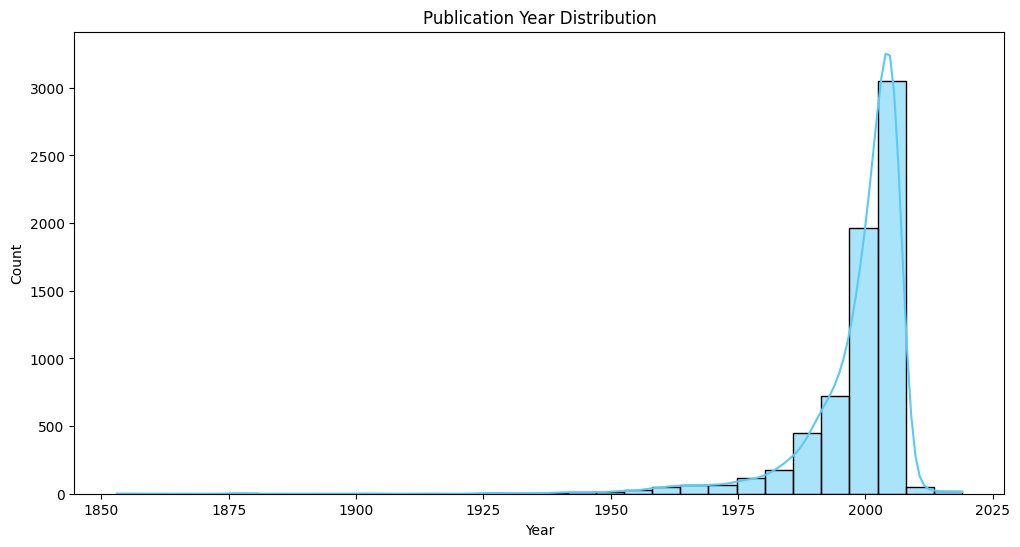

In [7]:
# Publication Year Trends
df['published_year'] = pd.to_numeric(df['published_year'], errors='coerce')
valid_years = df['published_year'].dropna()

plt.figure(figsize=(12, 6))
sns.histplot(valid_years, bins=30, kde=True, color='#56CBF9')
plt.title('Publication Year Distribution')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Interpretasi EDA: Distribusi Tahun Publikasi

*   **Konsentrasi pada Era Modern:** Sebagian besar buku dalam dataset diterbitkan dalam beberapa dekade terakhir. Puncak distribusi (jumlah buku terbanyak) berada di sekitar **awal tahun 2000-an**.
*   **Skewed Kiri (Long Tail ke Kiri):** Distribusinya sangat miring (skewed), dengan jumlah buku yang jauh lebih sedikit dari tahun-tahun yang lebih lama (misalnya, sebelum tahun 1975). Ada "ekor" panjang ke arah kiri (tahun-tahun lampau).
*   **Peningkatan Signifikan:** Jumlah buku mulai meningkat secara signifikan sejak sekitar tahun 1970-an dan mencapai puncaknya setelah tahun 2000.

**Kesimpulan:** Dataset ini didominasi oleh buku-buku yang relatif **modern atau baru diterbitkan**, dengan representasi yang jauh lebih kecil untuk buku-buku yang lebih tua.

<ipython-input-10-a1c2857f20d1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=authors.values, y=authors.index, palette='rocket')


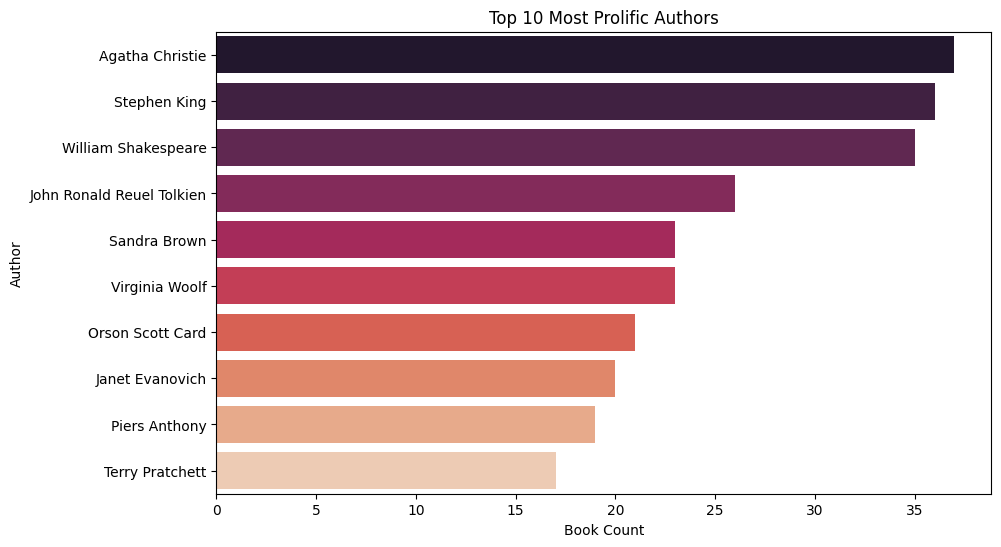

In [ ]:
# Author Popularity
authors = df['authors'].str.split(',').explode().str.strip().value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=authors.values, y=authors.index, palette='rocket')
plt.title('Top 10 Most Prolific Authors')
plt.xlabel('Book Count')
plt.ylabel('Author')
plt.show()

Interpretasi EDA: Top 10 Penulis Paling Produktif

*   **Penulis Teratas:** **Agatha Christie** dan **Stephen King** menempati posisi puncak, menunjukkan bahwa mereka memiliki representasi buku terbanyak dalam koleksi data ini (masing-masing lebih dari 35 buku). **William Shakespeare** juga sangat terwakili.
*   **Representasi Tinggi:** Penulis-penulis lain dalam daftar 10 besar (seperti J.R.R. Tolkien, Virginia Woolf, Sandra Brown, dll.) juga memiliki jumlah buku yang signifikan (umumnya antara 17 hingga 26 buku).
*   **Implikasi:** Ini menunjukkan bahwa karya dari penulis-penulis populer dan produktif ini cukup banyak tersedia dalam dataset, yang dapat mempengaruhi variasi rekomendasi, terutama jika pengguna menyukai karya salah satu penulis ini.

**Kesimpulan:** Dataset ini memiliki representasi yang kuat untuk beberapa penulis yang sangat produktif atau klasik, dengan Agatha Christie dan Stephen King sebagai yang paling dominan dalam hal jumlah karya yang disertakan.

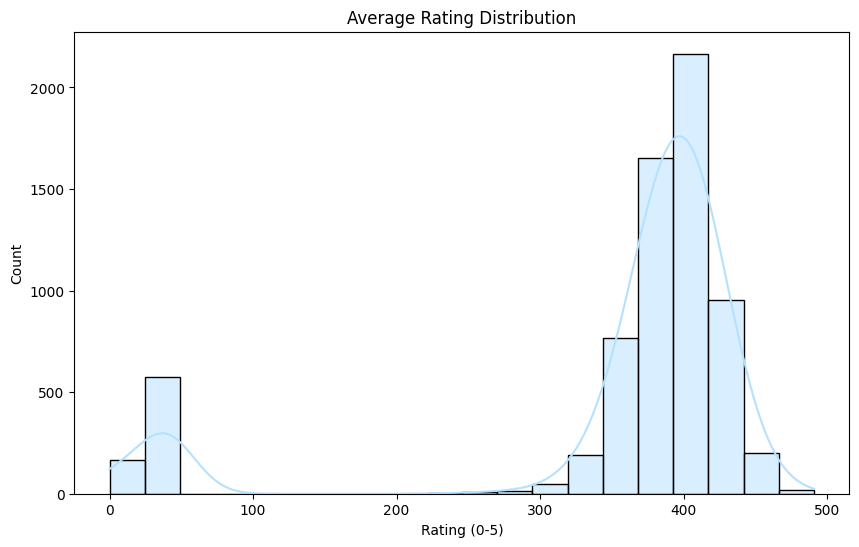

In [ ]:
# Average Rating Distribution
df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
valid_ratings = df['average_rating'].dropna()

plt.figure(figsize=(10, 6))
sns.histplot(valid_ratings, bins=20, kde=True, color='#B4E1FF')
plt.title('Average Rating Distribution')
plt.xlabel('Rating (0-5)')
plt.ylabel('Count')
plt.show()

Interpretasi EDA: Distribusi Rata-Rata Rating

*   **Dominasi Rating Tinggi:** Mayoritas buku cenderung memiliki **rating yang tinggi**. Puncak utama distribusi (jumlah buku terbanyak) berada di sekitar **rating 4.0** (dengan asumsi skala 0-5).
*   **Puncak Kecil di Rating Rendah:** Terdapat juga **kelompok kecil buku** dengan **rating sangat rendah** (mendekati 0 atau 1), yang terlihat sebagai puncak kedua yang jauh lebih kecil.
*   **Distribusi Bimodal:** Pola ini menunjukkan distribusi yang **bimodal** (dua puncak), yang berarti buku-buku cenderung dikelompokkan sebagai "disukai" (rating tinggi) atau "sangat tidak disukai" (rating sangat rendah), dengan lebih sedikit buku yang mendapat rating di tengah-tengah.

**Kesimpulan:** Sebagian besar buku dalam dataset ini memiliki ulasan positif (rating tinggi), namun ada juga sejumlah kecil buku dengan rating yang sangat buruk.

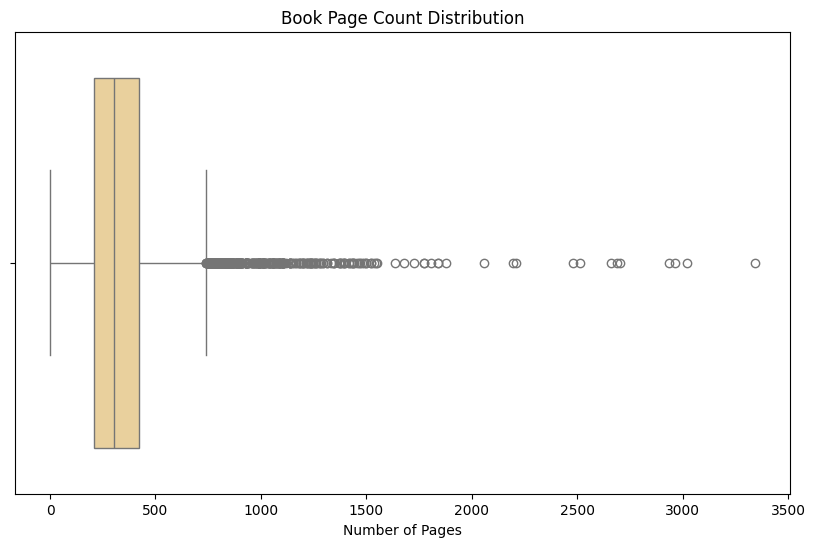

In [ ]:
# Page Count Analysis
df['num_pages'] = pd.to_numeric(df['num_pages'], errors='coerce')
valid_pages = df['num_pages'].dropna()

plt.figure(figsize=(10, 6))
sns.boxplot(x=valid_pages, color='#F5D491')
plt.title('Book Page Count Distribution')
plt.xlabel('Number of Pages')
plt.show()

Interpretasi EDA: Distribusi Jumlah Halaman Buku

*   **Konsentrasi Utama (Box):** Bagian kotak (box) menunjukkan bahwa 50% buku di tengah dataset memiliki jumlah halaman antara sekitar 150-200 hingga 350-400 halaman. Garis di dalam kotak (median) berada di sekitar 250-300 halaman, artinya setengah dari buku memiliki halaman lebih sedikit dari ini, dan setengahnya lebih banyak.
*   **Banyaknya Outlier:** Terdapat **sangat banyak titik** (outlier) di sebelah kanan *whisker* (garis horizontal). Ini menunjukkan bahwa meskipun mayoritas buku memiliki panjang moderat, ada **sejumlah besar buku dengan jumlah halaman yang sangat tinggi** (bisa mencapai lebih dari 1000, 2000, bahkan 3000 halaman) dibandingkan dengan sebagian besar buku lainnya.
*   **Distribusi Miring ke Kanan (Right-Skewed):** Keberadaan banyak outlier dengan nilai tinggi ini membuat distribusi jumlah halaman menjadi sangat **miring ke kanan**.

**Kesimpulan:** Sebagian besar buku dalam dataset memiliki jumlah halaman yang relatif standar (di bawah ~400 halaman), namun terdapat "ekor" panjang yang signifikan dari buku-buku yang sangat tebal.

In [ ]:
# Title Uniqueness Check
unique_titles = df['title'].nunique()
total_titles = len(df)
print(f"Unique Titles: {unique_titles}/{total_titles} ({unique_titles/total_titles:.1%})")

Unique Titles: 6397/6810 (93.9%)


Interpretasi EDA: Pemeriksaan Keunikan Judul

Kode ini memeriksa seberapa unik kolom `title` (judul) dalam dataset:

*   **Hasil:** Dari total **6810** entri buku, terdapat **6397** judul yang unik.
*   **Persentase:** Ini berarti **93.9%** dari buku dalam dataset memiliki judul yang berbeda satu sama lain.

**Kesimpulan:** Sebagian besar buku dalam dataset ini memiliki judul yang unik, menunjukkan bahwa duplikasi judul (buku yang sama persis dicatat berulang kali dengan judul yang sama) sangatlah minim.

In [ ]:
text_features = ['title', 'subtitle', 'categories', 'authors']
numeric_features = ['average_rating', 'num_pages', 'ratings_count', 'published_year']

Kode ini membuat dua **daftar (list)** Python untuk **mengelompokkan nama-nama kolom** dari sebuah dataset (kemungkinan DataFrame `df`) berdasarkan **tipe data** yang diharapkan.
*   **Detail:**
    *   `text_features`: Menyimpan nama-nama kolom yang dianggap berisi data **tekstual** atau kategorikal (`title`, `subtitle`, `categories`, `authors`).
    *   `numeric_features`: Menyimpan nama-nama kolom yang dianggap berisi data **numerik** (`average_rating`, `num_pages`, `ratings_count`, `published_year`).

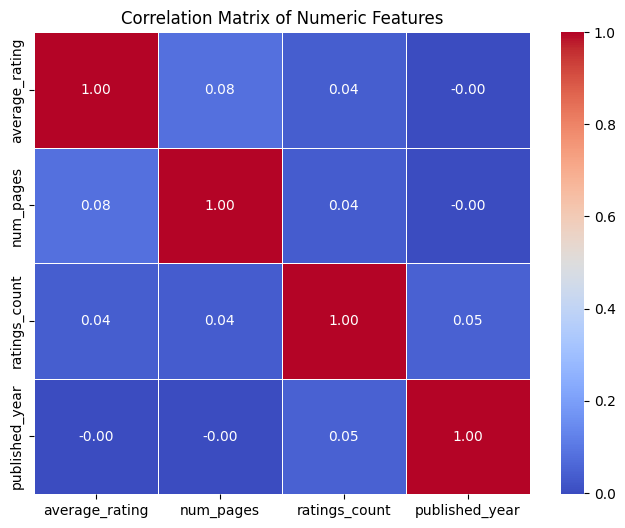


Correlation Matrix Values:
                average_rating  num_pages  ratings_count  published_year
average_rating        1.000000   0.082967       0.037342       -0.001119
num_pages             0.082967   1.000000       0.035768       -0.002641
ratings_count         0.037342   0.035768       1.000000        0.047258
published_year       -0.001119  -0.002641       0.047258        1.000000


In [ ]:
# Select only the numeric features for correlation analysis
numeric_df_for_corr = df[numeric_features]

# Calculate the correlation matrix
correlation_matrix = numeric_df_for_corr.corr()

# Create the heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Display the correlation matrix values (optional)
print("\nCorrelation Matrix Values:")
print(correlation_matrix)

Proses ini menghitung **matriks korelasi** antara semua pasangan kolom yang ada dalam daftar `numeric_features` dan kemudian **memvisualisasikannya** menggunakan heatmap untuk memudahkan interpretasi.
*   **Proses:**
    1.  Menghitung koefisien korelasi Pearson (nilai antara -1 dan 1) untuk setiap pasangan fitur numerik.
    2.  Membuat visualisasi heatmap di mana warna dan angka merepresentasikan nilai korelasi tersebut.

---

#### Interpretasi Visual: Correlation Matrix of Numeric Features

*   **Jenis Visualisasi:** Heatmap Matriks Korelasi.
*   **Tujuan:** Menampilkan **kekuatan dan arah hubungan linear** antara setiap pasangan fitur numerik (`average_rating`, `num_pages`, `ratings_count`, `published_year`).
*   **Pembacaan:**
    *   Setiap kotak menunjukkan koefisien korelasi antara fitur pada baris dan fitur pada kolom.
    *   **Nilai 1.00 (Merah Pekat):** Menunjukkan korelasi positif sempurna (terjadi pada diagonal karena setiap fitur berkorelasi sempurna dengan dirinya sendiri).
    *   **Nilai mendekati 0 (Biru/Ungu):** Menunjukkan tidak ada atau hubungan linear yang sangat lemah. Nilai negatif (jika ada, akan berwarna biru lebih pekat) menunjukkan hubungan terbalik.
    *   **Nilai dalam Kotak:** Angka eksplisit dari koefisien korelasi.
    *   **Skala Warna (Color Bar):** Memberikan panduan visual untuk nilai korelasi berdasarkan warna.
*   **Temuan Utama:**
    *   Berdasarkan visualisasi dan nilai yang ditampilkan (misalnya, 0.08, 0.04, -0.00, 0.05), terlihat bahwa **korelasi linear antara fitur-fitur numerik yang berbeda sangatlah lemah**. Tidak ada pasangan fitur yang menunjukkan hubungan linear yang kuat (nilai korelasi jauh dari 1 atau -1).

## Data Preparation

### Cleaning

In [ ]:
essential_text_features = ['title', 'authors', 'categories', 'published_year']
duplicate_check_subset = ['title']

# Clean Text Features
print("\nCleaning text features...")
for feature in text_features:
    if feature in df.columns:
        df[feature] = (
            df[feature]
            .fillna('')
            .astype(str)
            .str.replace('[^a-zA-Z0-9\\s]', '', regex=True)
            .str.replace(r'\\s+', ' ', regex=True)
            .str.strip()
            .str.lower()
        )
print("Text features cleaned.")

# Drop Rows with Empty Essential Text Features (Post-Cleaning)
print("\nDropping rows with empty essential text...")
initial_rows_before_text_drop = len(df)
# Create mask to keep rows where ALL essential features are non-empty
mask_to_keep_text = (df[essential_text_features].astype(str) != '').all(axis=1)
df = df[mask_to_keep_text].copy()
dropped_text_count = initial_rows_before_text_drop - len(df)
print(f"Dropped {dropped_text_count} rows missing essential text.")
df = df.reset_index(drop=True)
print(f"Rows remaining: {len(df)}")

# Clean Numeric Features with Imputation
print("\nCleaning numeric features...")
# Handle average_rating (use median)
if 'average_rating' in numeric_features and 'average_rating' in df.columns:
    df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
    median_rating = df['average_rating'].median()
    print(f"Impute average_rating NaNs with median: {median_rating:.2f}")
    df['average_rating'] = df['average_rating'].fillna(median_rating).astype(float)

# Handle other numeric features
for feature in numeric_features:
    if feature != 'average_rating' and feature in df.columns:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')
        if 'count' in feature or 'pages' in feature:
            # Impute counts/pages with 0
            df[feature] = df[feature].fillna(0).astype(int)
            print(f"Impute {feature} NaNs with 0")
        elif feature == 'published_year':
            # Impute year with median of valid years, fallback to 0
            valid_years = df[df['published_year'] > 0]['published_year']
            year_median = valid_years.median()
            if pd.notna(year_median):
                print(f"Impute published_year NaNs with median year: {int(year_median)}")
                df[feature] = df[feature].fillna(year_median).astype(int)
            else:
                print("Could not calculate median year, imputing year NaNs with 0")
                df[feature] = df[feature].fillna(0).astype(int)
        else:
            # Impute other numeric features with their median
            feature_median = df[feature].median()
            df[feature] = df[feature].fillna(feature_median).astype(float)
            print(f"Impute {feature} NaNs with median: {feature_median:.2f}")

print("Numeric features cleaned.")

# Drop Rows with Published Year = 0
print("\nDropping rows where 'published_year' is 0...")
initial_rows_before_year_drop = len(df)
if 'published_year' in df.columns:
    df = df[df['published_year'] != 0].copy()
    dropped_year_count = initial_rows_before_year_drop - len(df)
    print(f"Dropped {dropped_year_count} rows with year 0.")
    df = df.reset_index(drop=True)
    print(f"Rows remaining: {len(df)}")
else:
    print("Skipping year drop: 'published_year' column not found.")


# Handle Duplicates (Keep highest ratings_count)
print("\nChecking for duplicates...")
initial_rows_before_dup_drop = len(df)
# Check if all columns in subset exist
if all(col in df.columns for col in duplicate_check_subset):
    duplicates_found = df.duplicated(subset=duplicate_check_subset).sum()
    print(f"Found {duplicates_found} duplicates based on {duplicate_check_subset}.")

    if duplicates_found > 0 and 'ratings_count' in df.columns:
        # Keep the first occurrence (highest ratings_count) after sorting
        df = df.sort_values(by=['ratings_count'], ascending=False) # Sort by rating count first
        df = df.drop_duplicates(subset=duplicate_check_subset, keep='first') # Keep highest rated one
        df = df.reset_index(drop=True)

        duplicates_dropped = initial_rows_before_dup_drop - len(df)
        print(f"Dropped {duplicates_dropped} duplicates, kept highest ratings_count.")
        print(f"Final rows after deduplication: {len(df)}")
    elif duplicates_found > 0:
         # Simple duplicate drop if no ratings_count
         df = df.drop_duplicates(subset=duplicate_check_subset, keep='first')
         df = df.reset_index(drop=True)
         duplicates_dropped = initial_rows_before_dup_drop - len(df)
         print(f"Dropped {duplicates_dropped} duplicates (ratings_count not found for sorting).")
         print(f"Final rows after deduplication: {len(df)}")
    else:
        print("No duplicate rows to drop.")
else:
    print(f"Skipping duplicate check: One or more columns in {duplicate_check_subset} not found.")


# Final Preview & Checks
print("\nFinal Data Preview:")
# Define columns for preview, checking if they exist
preview_cols = [col for col in ['title', 'subtitle', 'authors', 'categories',
                               'published_year', 'average_rating', 'num_pages',
                               'ratings_count'] if col in df.columns]
if preview_cols:
    print(df[preview_cols].head())
else:
    print("No preview columns found.")


# Check for missing values in core features
print("\nMissing Values Check:")
final_check_cols = [col for col in text_features + numeric_features if col in df.columns]
if final_check_cols:
    print(df[final_check_cols].isnull().sum())
else:
    print("No core columns found to check.")

# Check final data types
print("\nData Types After Cleaning:")
if final_check_cols:
    print(df[final_check_cols].dtypes)
else:
    print("No core columns found to check types.")


Cleaning text features...
Text features cleaned.

Dropping rows with empty essential text...
Dropped 181 rows missing essential text.
Rows remaining: 6629

Cleaning numeric features...
Impute average_rating NaNs with median: 392.00
Impute num_pages NaNs with 0
Impute ratings_count NaNs with 0
Impute published_year NaNs with median year: 2002
Numeric features cleaned.

Dropping rows where 'published_year' is 0...
Dropped 0 rows with year 0.
Rows remaining: 6629

Checking for duplicates...
Found 417 duplicates based on ['title'].
Dropped 417 duplicates, kept highest ratings_count.
Final rows after deduplication: 6212

Final Data Preview:
                                             title subtitle  \
0      harry potter and the sorcerers stone book 1            
1                                         twilight            
2               the hobbit or there and back again            
3                                   angels  demons            
4  harry potter and the prisoner of azka

Kode ini bertujuan untuk membersihkan dan merapikan data (kemungkinan data buku) dalam sebuah tabel (`df`) agar siap digunakan untuk analisis selanjutnya.

#### 1. Membersihkan Kolom Teks
*   Memproses setiap kolom teks yang ditentukan (seperti judul, penulis, kategori).
*   Untuk setiap kolom teks:
    *   Mengisi bagian yang kosong (NaN) dengan teks kosong ('').
    *   Memastikan formatnya adalah teks (string).
    *   Menghapus semua karakter selain huruf, angka, dan spasi (misalnya tanda baca).
    *   Mengganti spasi yang berlebihan menjadi satu spasi saja.
    *   Menghapus spasi di awal atau akhir teks.
    *   Mengubah semua huruf menjadi huruf kecil.
*   **Tujuan:** Membuat data teks menjadi seragam dan bersih.

#### 2. Menghapus Baris dengan Teks Penting yang Kosong
*   Mencari baris data dimana ada informasi teks penting (seperti judul, penulis, kategori, tahun terbit) yang kosong *setelah* langkah pembersihan pertama.
*   Menghapus baris data yang tidak lengkap tersebut.
*   Menata ulang nomor urut baris data.
*   **Tujuan:** Memastikan setiap data punya informasi teks dasar yang lengkap.

#### 3. Membersihkan Kolom Angka & Mengisi Data Kosong
*   Memproses setiap kolom angka yang ditentukan (seperti tahun terbit, rating, jumlah halaman).
*   Mengubah format data di kolom ini menjadi format angka (jika ada yang bukan angka, akan jadi kosong/NaN).
*   Mengisi data angka yang kosong (NaN) dengan cara tertentu:
    *   `average_rating` (rata-rata rating): Diisi dengan **nilai tengah (median)** dari semua rating yang ada.
    *   Kolom yang namanya mengandung 'count' atau 'pages' (jumlah): Diisi dengan **angka 0**.
    *   `published_year` (tahun terbit): Diisi dengan **nilai tengah (median)** dari tahun-tahun yang valid (lebih besar dari 0). Jika tidak bisa dihitung, diisi **0**.
    *   Kolom angka lainnya: Diisi dengan **nilai tengah (median)** masing-masing kolom.
*   Mengubah format angka menjadi bilangan bulat (`int`) atau desimal (`float`) sesuai kebutuhan.
*   **Tujuan:** Menangani data angka yang hilang dan memastikan formatnya benar.

#### 4. Menghapus Baris dengan Tahun Terbit = 0
*   Menghapus baris data yang kolom `published_year` (tahun terbit) bernilai **0** (seringkali berarti data tidak valid).
*   Menata ulang nomor urut baris data.
*   **Tujuan:** Membuang data dengan tahun terbit yang tidak valid.

#### 5. Menangani Data Ganda (Duplikat)
*   Mengecek apakah ada baris data yang isinya sama persis berdasarkan kolom tertentu (dalam kode ini berdasarkan `'title'/judul`).
*   **Jika ada data duplikat:**
    *   Data akan diurutkan berdasarkan `ratings_count` (jumlah rating) dari yang terbanyak ke tersedikit (jika kolom ini ada).
    *   Data duplikat akan dihapus, tapi **menyimpan satu** data saja (yaitu data yang punya `ratings_count` tertinggi, jika ada).
*   Menata ulang nomor urut baris data.
*   **Tujuan:** Menghilangkan data ganda dan secara cerdas menyimpan versi data yang dianggap paling relevan (punya rating tertinggi).

#### 6. Pratinjau Akhir & Pengecekan
*   Menampilkan beberapa contoh baris data pertama dari kolom-kolom utama setelah dibersihkan.
*   Memeriksa ulang apakah masih ada data yang kosong di kolom-kolom utama.
*   Menampilkan format akhir data (teks, angka bulat, angka desimal) untuk kolom-kolom utama.
*   **Tujuan:** Memastikan proses pembersihan sudah benar dan data siap digunakan.

In [ ]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 6212 rows and 12 columns.


Output ini menunjukkan ukuran akhir dari tabel data (`df`) setelah semua proses pembersihan selesai.

*   Tabel data tersebut kini memiliki **6212 baris** data.
*   Tabel data tersebut kini memiliki **13 kolom** informasi (fitur).

In [ ]:
df.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.212000e+03,6212.000000,6212.000000,6212.000000,6.212000e+03
mean,9.780670e+12,1998.884095,354.416613,344.181101,2.260095e+04
std,5.962026e+08,10.058952,116.122673,238.831771,1.433250e+05
min,9.780000e+12,1876.000000,0.000000,0.000000,0.000000e+00
25%,9.780320e+12,1997.000000,367.000000,207.000000,1.660000e+02
50%,9.780550e+12,2002.000000,392.000000,304.000000,1.138500e+03
75%,9.780810e+12,2005.000000,411.000000,416.000000,6.770500e+03
max,9.789040e+12,2019.000000,491.000000,3342.000000,5.629932e+06


Output `describe()` ini memberikan ringkasan statistik untuk kolom-kolom numerik dalam DataFrame (`df`) setelah proses pembersihan data:

*   **Jumlah Data (`count`):** Semua kolom numerik yang ditampilkan (`isbn13`, `published_year`, `average_rating`, `num_pages`, `ratings_count`) memiliki **6212** data. Ini mengonfirmasi bahwa **tidak ada nilai yang hilang** (NaN) lagi di kolom-kolom ini setelah imputasi.

*   **`published_year` (Tahun Terbit):**
    *   Rata-rata tahun terbit adalah sekitar **1999**.
    *   Tahun terbit paling lama adalah **1876** dan paling baru **2019**.
    *   Setengah dari buku (median/50%) diterbitkan sebelum/sesudah tahun **2002**.
    *   Sebagian besar buku (75%) diterbitkan setelah tahun **1997**.

*   **`average_rating` (Rata-rata Rating):**
    *   Rata-rata rating adalah sekitar **354**.
    *   Nilai rating berkisar dari **0** hingga **491**. (Perlu diperhatikan skala rating yang digunakan, tampaknya bukan 1-5).
    *   Setengah dari buku (median/50%) memiliki rating di bawah/di atas **392**.
    *   Sebagian besar buku (75%) memiliki rating di atas **367**.

*   **`num_pages` (Jumlah Halaman):**
    *   Rata-rata jumlah halaman adalah **344**.
    *   Jumlah halaman berkisar dari **0** (mungkin hasil imputasi atau data tidak valid sebelumnya) hingga **3342** halaman.
    *   Setengah dari buku (median/50%) memiliki kurang/lebih dari **304** halaman.

*   **`ratings_count` (Jumlah Pemberi Rating):**
    *   Rata-rata jumlah pemberi rating adalah sekitar **22.600**.
    *   Jumlah pemberi rating sangat bervariasi, mulai dari **0** hingga **lebih dari 5,6 juta**.
    *   Setengah dari buku (median/50%) hanya memiliki kurang dari **1139** pemberi rating.
    *   **Perbedaan besar** antara rata-rata (22.600) dan median (1139) menunjukkan bahwa sebagian kecil buku sangat populer (memiliki jumlah rating sangat tinggi) dibandingkan mayoritas buku lainnya. Sebaran data ini sangat **miring (skewed)**.

*   **`isbn13`:** Meskipun ditampilkan, statistik seperti rata-rata (`mean`) atau standar deviasi (`std`) untuk ISBN biasanya tidak bermakna secara interpretatif karena ISBN adalah pengidentifikasi unik, bukan ukuran kuantitatif.

Secara keseluruhan, ringkasan ini menunjukkan bahwa data numerik sudah lengkap (tidak ada nilai hilang) dan memberikan gambaran tentang rentang, nilai tengah, dan sebaran untuk setiap fitur kuantitatif buku dalam dataset. Fitur `ratings_count` terlihat memiliki sebaran yang sangat tidak merata.

In [ ]:
# Drop unnecessary columns
columns_to_drop = [
    'isbn13',
    'isbn10',
    'thumbnail'
]

df = df.drop(columns=columns_to_drop)

# Total rows and columns in dataset
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 6212 rows and 9 columns.


Tujuan Penghapusan Kolom (`isbn13`, `isbn10`, `thumbnail`)

*   **Menghapus Kolom yang Tidak Relevan:** Kode ini bertujuan untuk menghapus kolom `isbn13`, `isbn10`, dan `thumbnail` dari dataset.
*   **Fokus pada Fitur Konten:** Alasan penghapusan adalah karena kolom-kolom ini (nomor ISBN dan tautan gambar) **tidak dianggap relevan secara langsung** untuk menghitung kemiripan **konten** antar buku dalam sistem rekomendasi berbasis konten (content-based filtering) yang sedang dibangun. Sistem ini lebih fokus pada fitur tekstual seperti judul, penulis, dan kategori.
*   **Efisiensi:** Menghilangkan kolom yang tidak perlu membuat dataset lebih ramping dan fokus pada fitur yang digunakan.

## Model Development

### Content-Based Filtering

In [ ]:
# Combining all the 4 selected features
content_based_features = df['title'] + ' ' + df['categories'] + ' ' + df['authors'] + ' ' + f"{df['published_year']}"
content_based_features

,0
0,harry potter and the sorcerers stone book 1 ju...
1,twilight young adult fiction stephenie meyer 0...
2,the hobbit or there and back again juvenile fi...
3,angels demons fiction dan brown 0 2015\...
4,harry potter and the prisoner of azkaban book ...
...,...
6207,courageous faith through the year religion bil...
6208,light fiction m john harrison 0 2015\n1 ...
6209,the last of the mohicans fiction james fenimor...
6210,a book of blue flowers gardening r l geneve 0 ...


Langkah ini bertujuan untuk membuat satu representasi teks tunggal yang merangkum informasi penting dari setiap buku dalam dataset.

#### 1. Proses Penggabungan Fitur
*   Kode mengambil data dari kolom-kolom yang relevan dengan konten buku:
    *   `title` (Judul)
    *   `categories` (Kategori/Genre)
    *   `authors` (Penulis)
    *   `published_year` (Tahun Terbit - dikonversi menjadi teks)
*   Untuk **setiap baris (buku)** dalam DataFrame:
    *   Nilai dari kolom-kolom di atas digabungkan menjadi satu string teks panjang.
    *   Spasi (`' '`) digunakan sebagai pemisah antar nilai kolom yang berbeda.
*   Hasilnya adalah sebuah Series Pandas (`content_based_features`) yang berisi string konten gabungan untuk setiap buku.

#### 2. Tujuan: Input untuk Vektorisasi TF-IDF
*   **Dokumen Input:** String konten gabungan (`content_based_features`) ini akan berfungsi sebagai **dokumen input** utama untuk `TfidfVectorizer`. Setiap string mewakili satu "dokumen" (satu buku).
*   **Analisis Holistik:** Dengan menggabungkan fitur-fitur ini, `TfidfVectorizer` dapat menganalisis **frekuensi kata (term frequency)** dan **kepentingannya secara keseluruhan (inverse document frequency)** di seluruh deskripsi konten gabungan tersebut.
*   **Perhitungan Kemiripan:** Proses ini memungkinkan model (seperti TF-IDF) untuk menghitung **kemiripan (similarity)** antar buku berdasarkan representasi konten yang lebih **holistik dan komprehensif**, tidak hanya berdasarkan satu fitur saja (misalnya judul).

In [ ]:
print("First few elements of content_based_features:")
print(content_based_features[:5] if len(content_based_features) >= 5 else content_based_features)
print(f"Total items: {len(content_based_features)}")

First few elements of content_based_features:
0    harry potter and the sorcerers stone book 1 ju...
1    twilight young adult fiction stephenie meyer 0...
2    the hobbit or there and back again juvenile fi...
3    angels  demons fiction dan brown 0       2015\...
4    harry potter and the prisoner of azkaban book ...
dtype: object
Total items: 6212


Output ini memberikan gambaran tentang variabel `content_based_features` yang telah dibuat:

*   **Contoh Data:** Menampilkan **lima elemen (baris) pertama** dari `content_based_features`.
    *   Setiap elemen mewakili **satu buku**.
    *   Isinya adalah **satu string teks panjang** yang merupakan **hasil penggabungan** dari:
        *   Judul (`title`)
        *   Kategori (`categories`)
        *   Penulis (`authors`)
        *   Tahun Terbit (`published_year`, sebagai teks)
    *   Contohnya menunjukkan judul seperti "harry potter and the sorcerers stone", "twilight", dll., yang digabung dengan informasi lainnya.

*   **Jumlah Total:** Menunjukkan bahwa total ada **6212 item (buku)** dalam `content_based_features`. Jumlah ini sesuai dengan jumlah baris data setelah proses pembersihan.

*   **Tujuan:** String gabungan ini siap digunakan sebagai input untuk langkah selanjutnya, yaitu proses vektorisasi menggunakan `TfidfVectorizer`, untuk mengubah teks ini menjadi representasi numerik yang dapat dipahami oleh model.

In [ ]:
# Converting the text data to feature vectors using more permissive settings
vectorizer = TfidfVectorizer(
    min_df=1,
    max_df=0.95,
    stop_words=None,
    token_pattern=r'(?u)\b\w+\b',
    lowercase=True
)

Langkah ini mempersiapkan alat (`TfidfVectorizer`) untuk mengubah data teks (seperti `content_based_features`) menjadi representasi vektor numerik menggunakan metode TF-IDF (Term Frequency-Inverse Document Frequency).

#### Pengaturan Parameter :

*   **`min_df=1`**:
    *   Mengatur **minimum frekuensi dokumen (document frequency)**.
    *   Nilai `1` berarti sebuah kata akan dimasukkan ke dalam kosakata (vocabulary) meskipun hanya muncul dalam **satu dokumen (buku)** saja. Ini adalah pengaturan yang paling **longgar/permisif**.

*   **`max_df=0.95`**:
    *   Mengatur **maksimum frekuensi dokumen**.
    *   Nilai `0.95` berarti kata-kata yang muncul di **lebih dari 95%** dari total dokumen akan **diabaikan**.
    *   Tujuannya adalah untuk mengabaikan kata-kata yang terlalu umum dalam *seluruh dataset* ini, yang mungkin tidak membantu membedakan antar buku.

*   **`stop_words=None`**:
    *   Menentukan daftar kata umum (stop words) yang akan dihapus.
    *   Nilai `None` berarti **tidak ada daftar stop words bawaan** yang akan digunakan oleh vectorizer ini. Penghapusan stop words mungkin sudah dilakukan pada tahap pembersihan sebelumnya, atau akan ditangani oleh parameter `max_df`.

*   **`token_pattern=r'(?u)\b\w+\b'`**:
    *   Mendefinisikan pola (regular expression) untuk mengidentifikasi **token (kata)**.
    *   Pola ini secara efektif menemukan **urutan karakter kata** (huruf, angka, garis bawah) yang dibatasi oleh "batas kata" (`\b`), termasuk token satu karakter (seperti 'a' atau '1'). `(?u)` memastikan kompatibilitas Unicode.

*   **`lowercase=True`**:
    *   Memastikan **semua teks diubah menjadi huruf kecil** *sebelum* diproses lebih lanjut (tokenisasi dan perhitungan frekuensi). Ini standar agar kata seperti "Buku" dan "buku" dianggap sama.

#### Tujuan Keseluruhan :
*   Menginisialisasi `TfidfVectorizer` dengan pengaturan yang cukup permisif (`min_df=1`, `stop_words=None`) untuk memastikan sebagian besar kata dipertahankan, sambil mengabaikan kata yang sangat umum di seluruh dataset (`max_df=0.95`).
*   Vectorizer ini siap digunakan untuk `fit_transform` pada data teks gabungan (`content_based_features`) untuk membuat matriks TF-IDF.

In [ ]:
# Converting the text data to feature vectors
vectorizer = TfidfVectorizer()

feature_vectors = vectorizer.fit_transform(content_based_features)
print(feature_vectors)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 150095 stored elements and shape (6212, 11155)>
  Coords	Values
  (0, 4480)	0.3156490054888486
  (0, 7954)	0.31749921621432414
  (0, 451)	0.16596158509720824
  (0, 9946)	0.0944254289288635
  (0, 9372)	0.44324525672657755
  (0, 9601)	0.3444651088408824
  (0, 1276)	0.269650556574953
  (0, 5403)	0.16288874827968775
  (0, 3582)	0.08413154754326278
  (0, 8592)	0.3554046690945688
  (0, 5291)	0.3752825008974288
  (0, 92)	0.09804953079986026
  (0, 89)	0.1470742961997904
  (0, 84)	0.04902476539993013
  (0, 115)	0.04902476539993013
  (0, 87)	0.09804953079986026
  (0, 116)	0.04902476539993013
  (0, 117)	0.04902476539993013
  (0, 88)	0.04902476539993013
  (0, 118)	0.04902476539993013
  (0, 119)	0.04902476539993013
  (0, 73)	0.04902476539993013
  (0, 7053)	0.04902476539993013
  (0, 8089)	0.04902476539993013
  (0, 5901)	0.04902476539993013
  :	:
  (6211, 9946)	0.09657868728887781
  (6211, 92)	0.10028543244505514
  (6211, 89)	0.15042814866

Langkah ini mengubah data teks gabungan (`content_based_features`) menjadi representasi numerik menggunakan `TfidfVectorizer`.

#### Inisialisasi `TfidfVectorizer`
*   Kode `vectorizer = TfidfVectorizer()` membuat sebuah objek `TfidfVectorizer` dengan **pengaturan default**.
*   Ini berarti ia akan menggunakan aturan bawaan untuk tokenisasi (memecah teks menjadi kata), menghapus stop words umum bahasa Inggris (jika terdeteksi), dan menghitung skor TF-IDF.

Proses `fit_transform`
*   Kode `feature_vectors = vectorizer.fit_transform(content_based_features)` melakukan dua hal utama:
    *   **`fit`**: `vectorizer` "mempelajari" kosakata (semua kata unik) dari seluruh `content_based_features` dan menghitung bobot IDF (Inverse Document Frequency) untuk setiap kata.
    *   **`transform`**: `vectorizer` mengubah setiap string teks dalam `content_based_features` menjadi **vektor numerik**. Setiap elemen dalam vektor mewakili sebuah kata dari kosakata, dan nilainya adalah **skor TF-IDF** kata tersebut dalam teks (dokumen) tersebut.
*   Hasilnya (`feature_vectors`) adalah **matriks sparse**. Matriks ini secara efisien menyimpan skor TF-IDF, di mana sebagian besar nilainya adalah nol (karena kebanyakan kata tidak muncul di setiap dokumen).

Output Hasil `print(feature_vectors)`
*   Perintah `print` menampilkan representasi ringkas dari **matriks sparse** `feature_vectors`.
*   Outputnya biasanya akan menunjukkan:
    *   **Indeks baris dan kolom** dari elemen yang **bukan nol**.
    *   **Nilai skor TF-IDF** pada posisi tersebut.
    *   Contoh format: `(indeks_dokumen, indeks_kata) skor_tfidf`
*   Output ini **bukan** matriks penuh (karena terlalu besar), melainkan hanya ringkasan elemen-elemen penting (yang bernilai). Ini mengonfirmasi bahwa proses transformasi teks menjadi vektor numerik telah berhasil dilakukan. Vektor fitur ini siap digunakan untuk menghitung kemiripan.

In [ ]:
# Calculating similarity scores between items using cosine similarity
similarity = cosine_similarity(feature_vectors, feature_vectors)
print(similarity)

[[1.         0.09078334 0.13441895 ... 0.1142723  0.16985359 0.08532477]
 [0.09078334 1.         0.08440513 ... 0.10434888 0.09565478 0.08479773]
 [0.13441895 0.08440513 1.         ... 0.10624382 0.07992272 0.07933007]
 ...
 [0.1142723  0.10434888 0.10624382 ... 1.         0.12012317 0.10855683]
 [0.16985359 0.09565478 0.07992272 ... 0.12012317 1.         0.08792246]
 [0.08532477 0.08479773 0.07933007 ... 0.10855683 0.08792246 1.        ]]


Langkah ini menghitung seberapa mirip setiap item (buku) dengan setiap item lainnya berdasarkan representasi vektor fitur TF-IDF yang telah dibuat.

#### Proses Perhitungan
*   Kode menggunakan fungsi `cosine_similarity` dari pustaka `sklearn.metrics.pairwise`.
*   Fungsi ini menerima `feature_vectors` (matriks TF-IDF) sebagai input *dua kali*. Ini berarti kita menghitung kemiripan antara **setiap baris (buku)** dalam matriks dengan **setiap baris lainnya**, termasuk dirinya sendiri.
*   Cosine similarity mengukur kosinus sudut antara dua vektor. Semakin kecil sudutnya (semakin mirip arah vektornya), semakin dekat nilainya ke 1.

#### Output Hasil (`similarity`)
*   Variabel `similarity` berisi sebuah **matriks persegi (square matrix)**.
*   Jumlah baris dan kolom matriks ini sama dengan jumlah buku dalam dataset (misalnya, 6212 x 6212).
*   Setiap **elemen `[i, j]`** dalam matriks ini mewakili **skor cosine similarity** antara **buku ke-`i`** dan **buku ke-`j`**.

#### Interpretasi Nilai dalam Matriks (Contoh Output):
*   **Diagonal Utama:** Semua nilai pada diagonal utama (misalnya `[0, 0]`, `[1, 1]`, ..., `[akhir, akhir]`) adalah **`1.0`**. Ini karena kemiripan sebuah buku dengan dirinya sendiri selalu sempurna (maksimal).
*   **Elemen Lain (Off-diagonal):** Nilai-nilai lain dalam matriks (misalnya `[0, 1]` adalah `0.0907...`, `[0, 2]` adalah `0.1344...`) menunjukkan tingkat kemiripan antara **dua buku yang berbeda**.
    *   Nilai berkisar antara **0** (tidak ada kemiripan berdasarkan fitur yang diekstraksi) hingga **1** (kemiripan sempurna).
    *   Semakin **tinggi** nilainya (mendekati 1), semakin **mirip** kedua buku tersebut berdasarkan konten gabungan mereka (judul, kategori, penulis, tahun).
*   **Matriks Simetris:** Nilai `similarity[i, j]` akan sama dengan `similarity[j, i]` (kemiripan buku A ke B sama dengan B ke A).

#### Tujuan Keseluruhan:
*   Matriks `similarity` ini adalah **inti** dari sistem rekomendasi berbasis konten. Matriks ini menyimpan informasi kuantitatif tentang seberapa mirip setiap pasangan buku dalam dataset.
*   Matriks ini akan digunakan pada langkah selanjutnya untuk menemukan buku-buku yang paling mirip dengan buku yang dipilih pengguna.

In [ ]:
list_of_all_titles = df['title'].tolist()
print(list_of_all_titles)

['harry potter and the sorcerers stone book 1', 'twilight', 'the hobbit or there and back again', 'angels  demons', 'harry potter and the prisoner of azkaban book 3', 'harry potter and the chamber of secrets book 2', 'the fellowship of the ring', 'harry potter and the order of the phoenix book 5', 'harry potter and the halfblood prince book 6', 'lord of the flies', 'romeo and juliet', 'the alchemist', 'robert langdon novels', 'the giver', 'jane eyre', 'eat pray love', 'charlottes web full color', 'water for elephants', 'brave new world', 'wuthering heights', 'the curious incident of the dog in the nighttime', 'my sisters keeper', 'the handmaids tale', 'the shining', 'holes', 'frankenstein or the modern prometheus', 'the glass castle', 'the secret garden', 'dracula', 'the devil wears prada', 'the picture of dorian gray', 'a tale of two cities', 'the princess bride', 'a wrinkle in time', 'tuesdays with morrie', 'outlander', 'a clash of kings', 'the percy jackson and the olympians book tw

Langkah ini secara spesifik mengekstrak semua judul buku dari DataFrame dan menyusunnya menjadi sebuah daftar.

*   **Membuat Daftar Semua Judul:** Kode ini bertujuan untuk mengambil semua nilai dari kolom `title` dalam DataFrame `df` dan menyimpannya ke dalam sebuah **list Python standar**.
*   **Keperluan Pencocokan:** Daftar ini (`list_of_all_titles`) akan digunakan nanti untuk **mencari kecocokan** terdekat antara judul buku yang dimasukkan oleh pengguna dengan judul yang ada di dataset (misalnya menggunakan `difflib`).

In [ ]:
# Asking the user to input a book name
book_name = input(' Enter your favourite book name : ')

# Finding the close match for the book name given by the user
find_close_match = difflib.get_close_matches(book_name, list_of_all_titles)
print(find_close_match)

 Enter your favourite book name : babi
['babbitt', 'babyville']


*   **Menerima Preferensi Pengguna:** Kode ini bertujuan untuk meminta pengguna memasukkan **judul buku favorit** mereka sebagai input.
*   **Menangani Kesalahan Input:** Kemudian, kode ini menggunakan `difflib` untuk **mencari judul buku yang paling mirip** dalam dataset (`list_of_all_titles`) dengan input pengguna, guna mengatasi kemungkinan salah ketik atau variasi kecil pada judul yang dimasukkan.

In [ ]:
# Find the index of the book with title
close_match = find_close_match[0]
index_of_the_book = df[df.title == close_match].index[0]

# Creating a list of books along with their similarity scores
similarity_score = list(enumerate(similarity[index_of_the_book]))
print(similarity_score)

[(0, np.float64(0.11751237658026188)), (1, np.float64(0.13076236390671514)), (2, np.float64(0.10925626060727606)), (3, np.float64(0.15968873938895886)), (4, np.float64(0.11416877167214165)), (5, np.float64(0.11773928153633476)), (6, np.float64(0.16020514803709301)), (7, np.float64(0.1127542362451628)), (8, np.float64(0.11722655176004391)), (9, np.float64(0.15275917687150797)), (10, np.float64(0.13346451634583884)), (11, np.float64(0.16780707277301884)), (12, np.float64(0.10813891765149598)), (13, np.float64(0.16067600558818754)), (14, np.float64(0.144384301114578)), (15, np.float64(0.12104900410594832)), (16, np.float64(0.13553699290576565)), (17, np.float64(0.12876185599841364)), (18, np.float64(0.14555327204022203)), (19, np.float64(0.12127743937482788)), (20, np.float64(0.10978765753432732)), (21, np.float64(0.13578042841144908)), (22, np.float64(0.15202923040193464)), (23, np.float64(0.1464744105064393)), (24, np.float64(0.13444167848766958)), (25, np.float64(0.11693470421814307)),

Langkah ini bertujuan untuk mendapatkan daftar skor kemiripan antara buku yang dipilih pengguna (atau hasil pencocokan terdekat) dengan semua buku lain dalam dataset.

#### Menemukan Indeks Buku Pilihan
*   **Input:** Menggunakan `close_match` (variabel yang berisi judul buku hasil pencocokan terdekat, diasumsikan sudah didapat sebelumnya).
*   **Proses:** Mencari baris data di DataFrame `df` di mana kolom `'title'` sama dengan `close_match`. Kemudian, mengambil **nomor baris (indeks)** dari baris tersebut.
*   **Hasil:** Mendapatkan `index_of_the_book`, yaitu lokasi numerik (indeks) dari buku yang dipilih di dalam DataFrame dan matriks kemiripan.

#### Mengekstrak dan Memasangkan Skor Kemiripan
*   **Input:** Menggunakan `index_of_the_book` dan matriks kemiripan `similarity`.
*   **Proses:**
    *   Mengambil **seluruh baris** dari matriks `similarity` yang posisinya sesuai dengan `index_of_the_book`. Baris ini berisi skor kemiripan antara buku pilihan dengan *semua* buku lain (termasuk dirinya sendiri).
    *   Menggunakan fungsi `enumerate` untuk membuat pasangan data. Setiap pasangan terdiri dari:
        *   Nomor indeks buku lain (dari 0 hingga jumlah buku - 1).
        *   Skor kemiripan buku tersebut dengan buku pilihan.
*   **Hasil:** Membuat variabel `similarity_score` yang berupa **list Python**. Setiap elemen dalam list ini adalah sebuah **pasangan (tuple)** dengan format: `(indeks_buku_lain, skor_kemiripan_dengan_buku_pilihan)`.

#### Menampilkan Hasil (`print`)
*   Output `print(similarity_score)` akan menampilkan daftar pasangan skor kemiripan ini, yang siap untuk diurutkan guna menemukan buku-buku yang paling mirip.

In [ ]:
# Ranking the books in descending order based on similarity scores
sorted_similar_books = sorted(similarity_score, key = lambda x:x[1], reverse = True)
print(sorted_similar_books)

[(4365, np.float64(1.0)), (1690, np.float64(0.6337292550463606)), (4238, np.float64(0.5629623768440793)), (4312, np.float64(0.45123878119571775)), (3345, np.float64(0.379953059598074)), (4309, np.float64(0.36919243239162514)), (4767, np.float64(0.36564696245768336)), (4886, np.float64(0.36564696245768336)), (4066, np.float64(0.3497294098650343)), (5022, np.float64(0.3435601018764124)), (2945, np.float64(0.33001418747141703)), (4558, np.float64(0.32723815980068593)), (204, np.float64(0.3267386588686162)), (6026, np.float64(0.3186814408677098)), (57, np.float64(0.31725297994046875)), (103, np.float64(0.3095627660620467)), (1670, np.float64(0.30715124228203505)), (4789, np.float64(0.30546729681795204)), (785, np.float64(0.29121698388826606)), (4021, np.float64(0.28898636020919777)), (2526, np.float64(0.28620174410318794)), (3764, np.float64(0.2839173212947118)), (2808, np.float64(0.2793884247599531)), (2443, np.float64(0.2741834477340553)), (5150, np.float64(0.2656683430063909)), (3806, n

Langkah ini mengambil daftar skor kemiripan (yang kemungkinan berisi pasangan indeks buku dan skor kemiripannya) dan mengurutkannya untuk membuat peringkat rekomendasi.

#### Proses Pengurutan
*   **Input:** Variabel `similarity_score`. Variabel ini diasumsikan berisi sebuah daftar (list), di mana setiap elemennya adalah pasangan data, kemungkinan besar seperti `(indeks_buku, skor_kemiripan_buku_tersebut)`.
*   **Kriteria Pengurutan:** Menggunakan fungsi `sorted` dengan argumen:
    *   `key=lambda x: x[1]`: Menentukan bahwa pengurutan harus didasarkan pada **elemen kedua** dari setiap pasangan (yaitu, **skor kemiripan**).
    *   `reverse=True`: Menentukan bahwa pengurutan dilakukan secara **menurun**, dari nilai terbesar ke terkecil.

#### Hasil Pengurutan
*   **Output:** Variabel `sorted_similar_books` berisi daftar pasangan `(indeks_buku, skor_kemiripan)` yang **sama** seperti input, tetapi sekarang **sudah terurut**.
*   **Urutan Prioritas:** Buku-buku yang paling mirip (memiliki skor kemiripan **tertinggi**) dengan buku referensi akan berada di **posisi teratas** (awal) dalam daftar `sorted_similar_books`.

#### Tujuan
*   **Membuat Peringkat Rekomendasi:** Menyusun daftar buku berdasarkan seberapa relevan atau miripnya mereka dengan buku yang dijadikan acuan (buku input pengguna).
*   **Memudahkan Pengambilan Rekomendasi:** Daftar yang terurut ini memudahkan untuk mengambil sejumlah `N` buku teratas sebagai rekomendasi final yang akan ditampilkan kepada pengguna.

In [ ]:
top_sim = sorted_similar_books[:5]
top_sim

[(4365, np.float64(1.0)),
 (1690, np.float64(0.6337292550463606)),
 (4238, np.float64(0.5629623768440793)),
 (4312, np.float64(0.45123878119571775)),
 (3345, np.float64(0.379953059598074))]

Langkah ini fokus pada pemilihan sejumlah kecil rekomendasi buku terbaik dari daftar yang sudah diurutkan berdasarkan kemiripan.

#### Proses Seleksi (Slicing)
*   **Sumber Data:** Menggunakan daftar `sorted_similar_books`. Daftar ini diasumsikan **sudah diurutkan sebelumnya** berdasarkan skor kemiripan (cosine similarity), dari yang tertinggi ke terendah.
*   **Tindakan:** Kode `[:5]` melakukan **slicing** pada daftar tersebut, yaitu mengambil **irisan** yang berisi **lima elemen pertama** (dari indeks 0 hingga 4).
*   **Hasil:** Variabel `top_sim` kini berisi sebuah list baru yang hanya terdiri dari lima elemen teratas dari `sorted_similar_books`.

#### Tujuan dan Makna
*   **Mendapatkan Top-N Rekomendasi:** Karena `sorted_similar_books` sudah diurutkan berdasarkan kemiripan, lima elemen pertama ini secara otomatis mewakili **lima buku yang paling mirip** dengan buku referensi/input pengguna.
*   **Termasuk Buku Input:** Biasanya, elemen pertama dalam `sorted_similar_books` (dan oleh karena itu juga dalam `top_sim`) adalah buku referensi itu sendiri, karena memiliki skor kemiripan 1.0 (atau mendekati 1.0) dengan dirinya sendiri.
*   **Rekomendasi Final (Subset):** Daftar `top_sim` ini merupakan **subset** dari semua kemungkinan buku mirip, yang dipilih sebagai rekomendasi **teratas (Top 5)** untuk disajikan kepada pengguna.

In [ ]:
# Display the titles of the top similar books based on their index
i = 1

for book in sorted_similar_books:
    index = book[0]
    title_from_index = df[df.index==index]['title'].values[0]
    if (i < 6):
        print(i, '-', title_from_index)
        i += 1

1 - babbitt
2 - arrowsmith
3 - main street
4 - cs lewis
5 - the complete c s lewis signature classics


Kode ini bertugas untuk menampilkan hasil rekomendasi buku kepada pengguna dalam format yang mudah dibaca, yaitu berupa daftar judul buku yang paling mirip.

#### Proses Kerja:

*  **Iterasi Melalui Hasil Urutan:**
    *   Kode melakukan perulangan (`for loop`) pada `sorted_similar_books`. Diasumsikan variabel ini berisi daftar buku yang sudah **diurutkan** berdasarkan skor kemiripan tertinggi ke terendah.
    *   Setiap elemen (`book`) dalam daftar ini kemungkinan berisi pasangan `(indeks_buku, skor_kemiripan)`.

*  **Ekstraksi Indeks:**
    *   Di dalam setiap iterasi, **indeks unik** dari buku yang mirip diekstrak (`index = book[0]`).

*  **Pencarian Judul:**
    *   Indeks yang didapat digunakan untuk **mencari kembali** baris yang sesuai dalam DataFrame asli (`df`).
    *   Dari baris yang ditemukan, **nilai kolom 'title' (judul)** diambil (`df[df.index==index]['title'].values[0]`).

*  **Pembatasan dan Tampilan Hasil:**
    *   Sebuah **kondisi (`if i < 6`)** digunakan untuk **membatasi** jumlah output hanya **5 judul teratas**.
    *   Sebuah **penghitung (`i`)** digunakan untuk memberi nomor urut pada hasil.
    *   Jika kondisi terpenuhi (kurang dari 5 judul sudah ditampilkan), **nomor urut (`i`)** dan **judul buku (`title_from_index`)** dicetak ke layar.
    *   Penghitung `i` ditambahkan satu (`i += 1`) untuk iterasi selanjutnya.

### K-Means

In [ ]:
clustering_features_cols = ['average_rating', 'num_pages', 'ratings_count']

#### Isi Variabel:
*   Variabel ini berisi sebuah **`list`** yang mencantumkan nama-nama kolom spesifik dari DataFrame:
    *   `'average_rating'` (Rata-rata Rating)
    *   `'num_pages'` (Jumlah Halaman)
    *   `'ratings_count'` (Jumlah Pemberi Rating)

#### Tujuan:
*   **Pemilihan Fitur:** Daftar ini secara eksplisit **memilih kolom-kolom** yang akan digunakan sebagai **fitur input** untuk **algoritma clustering** (misalnya K-Means).
*   **Karakteristik Kuantitatif:** Kolom-kolom yang dipilih bersifat **kuantitatif (numerik)** dan mewakili **karakteristik buku** yang berbeda (seperti rata-rata rating, jumlah halaman, dan jumlah pemberi rating/popularitas).
*   **Dasar Pengelompokan:** Nilai-nilai dari kolom-kolom inilah yang akan dianalisis oleh algoritma clustering untuk mencoba **menemukan kelompok-kelompok (cluster)** alami dalam data buku berdasarkan kesamaan karakteristik kuantitatif tersebut.


In [ ]:
# Prepare features for K-means clustering (Scale data)
def features_for_clustering(df, feature_cols):
    scaler = RobustScaler()
    try:
        # Select only the specified numeric columns
        numeric_data = df[feature_cols].copy()
        # Check for and handle potential infinite values before scaling
        numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Check for NaNs *after* replacing infs
        if numeric_data.isnull().any().any():
             print(f"Warning: NaNs found in features before scaling: \n{numeric_data.isnull().sum()}")
             # Simple imputation with median for demonstration, adjust if needed
             for col in feature_cols:
                 if numeric_data[col].isnull().any():
                     median_val = numeric_data[col].median()
                     numeric_data[col].fillna(median_val, inplace=True)
                     print(f"  Filled NaNs in '{col}' with median: {median_val}")

        numeric_data_scaled = scaler.fit_transform(numeric_data)
        print(f"Using numeric features for clustering: {feature_cols}")
        print(f"Number of features used: {len(feature_cols)}")
        return numeric_data_scaled
    except KeyError as e:
        print(f"Error: Column not found in DataFrame - {e}")
        return None
    except Exception as e:
        print(f"Error during feature scaling: {e}")
        return None

print("\nPreparing features for clustering...")
# Make sure 'df' is your cleaned DataFrame from previous steps
if 'df' in locals() and isinstance(df, pd.DataFrame):
    clustering_features_scaled = features_for_clustering(df, clustering_features_cols)
    if clustering_features_scaled is not None:
        print("Features prepared successfully.")
        print(f"Shape of clustering features: {clustering_features_scaled.shape}")
    else:
        print("Feature preparation failed.")
else:
    print("Error: DataFrame 'df' not found or is not a DataFrame.")
    clustering_features_scaled = None


Preparing features for clustering...
Using numeric features for clustering: ['average_rating', 'num_pages', 'ratings_count']
Number of features used: 3
Features prepared successfully.
Shape of clustering features: (6212, 3)


Kode ini menyiapkan fitur numerik dari DataFrame (`df`) untuk clustering menggunakan `RobustScaler`.

#### Fungsi `features_for_clustering`:
1.  **Input:** DataFrame `df` dan daftar kolom numerik (`feature_cols`).
2.  **Scaling:** Menggunakan `RobustScaler` (tahan outlier).
3.  **Seleksi:** Memilih kolom dalam `feature_cols`.
4.  **Pembersihan:** Mengganti nilai `inf` menjadi `NaN`, lalu mengisi `NaN` yang tersisa dengan median kolom.
5.  **Transformasi:** Melakukan scaling data.
6.  **Output:** Mengembalikan data yang sudah di-scaling atau `None` jika error.

#### Kode Pemanggil:
*   Memastikan `df` ada, lalu memanggil fungsi `features_for_clustering`.
*   Menampilkan pesan sukses/gagal dan bentuk data hasil scaling.

---

#### Hasil Output:
Output mengonfirmasi bahwa tiga fitur numerik ('average\_rating', 'num\_pages', 'ratings\_count') berhasil dipilih dan di-scaling untuk 6212 buku, menghasilkan data berdimensi (6212, 3) yang siap untuk clustering.


Calculating scores for k=2 to k=10...
  k=2: Inertia=1135790.06, Silhouette=0.976
  k=3: Inertia=637926.37, Silhouette=0.969
  k=4: Inertia=304393.19, Silhouette=0.923
  k=5: Inertia=204512.70, Silhouette=0.842
  k=6: Inertia=154073.37, Silhouette=0.813
  k=7: Inertia=114825.52, Silhouette=0.716
  k=8: Inertia=87752.41, Silhouette=0.737
  k=9: Inertia=69723.95, Silhouette=0.737
  k=10: Inertia=55151.70, Silhouette=0.738


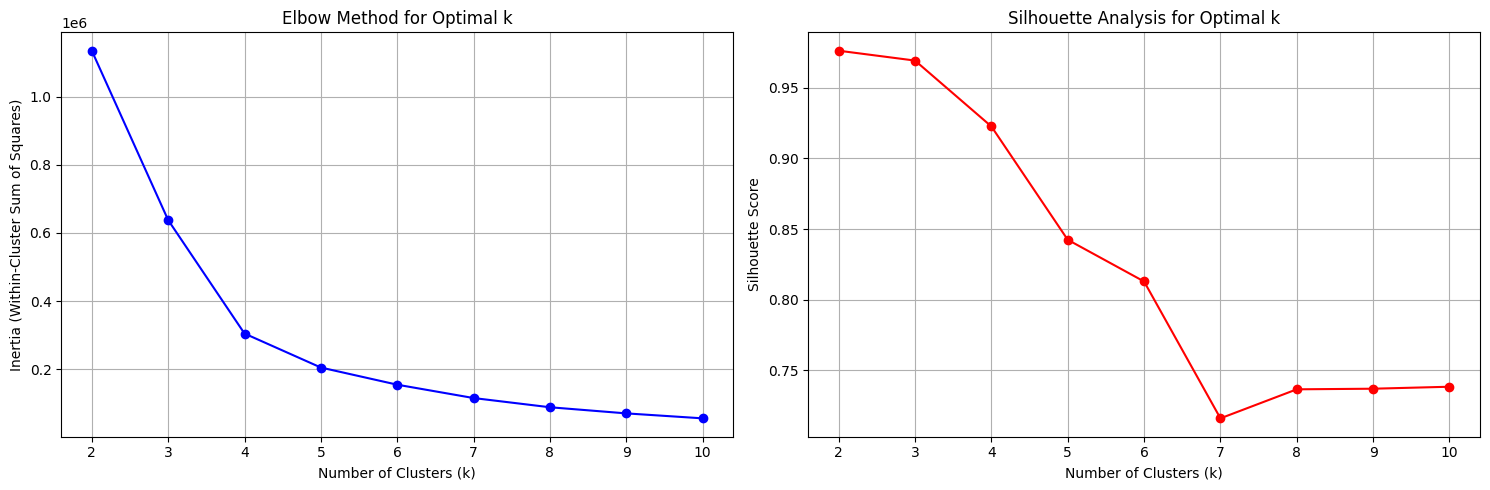


Optimal k suggested by highest Silhouette Score: 2


In [ ]:
def find_and_plot_optimal_k(features, max_k=10):
    if features is None:
        print("Cannot find optimal k without features.")
        return None

    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    print(f"\nCalculating scores for k=2 to k={max_k}...")
    for k in k_range:
        # Apply K-Means for the current k
        kmeans_analysis = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_analysis.fit(features)
        inertias.append(kmeans_analysis.inertia_)

        # Calculate Silhouette Score
        # Note: Can be slow for large datasets. Consider sampling if needed.
        score = silhouette_score(features, kmeans_analysis.labels_)
        silhouette_scores.append(score)
        print(f"  k={k}: Inertia={kmeans_analysis.inertia_:.2f}, Silhouette={score:.3f}")

    # Plot elbow curve (Inertia)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # Create figure with two subplots

    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.grid(True)

    # Plot Silhouette Scores
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis for Optimal k')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find k with the highest silhouette score
    if silhouette_scores: # Check if list is not empty
        optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
        print(f"\nOptimal k suggested by highest Silhouette Score: {optimal_k_silhouette}")
        return optimal_k_silhouette
    else:
        print("\nCould not determine optimal k from silhouette scores.")
        return None # Or a default value like 2


# Call the function to plot Elbow and Silhouette, but don't use its return value for final k
if clustering_features_scaled is not None:
    # Calculate and plot scores, store the suggested optimal k if needed for comparison
    suggested_optimal_k = find_and_plot_optimal_k(clustering_features_scaled, max_k=10)
else:
    print("Skipping optimal k analysis due to feature preparation error.")

Visualisasi ini menggunakan dua metode untuk membantu menentukan jumlah cluster (k) yang paling baik untuk algoritma K-Means berdasarkan data fitur yang telah disiapkan:

**1. Elbow Method (Grafik Kiri - Biru):**
*   **Metode:** Menampilkan penurunan nilai *Inertia* (Within-Cluster Sum of Squares/WCSS) seiring penambahan jumlah cluster (k). Kita mencari titik "siku" (elbow) di mana penurunan mulai melambat secara signifikan, menandakan penambahan cluster selanjutnya tidak lagi memberikan pengurangan varians internal yang berarti.
*   **Observasi:** Grafik menunjukkan penurunan tajam dari k=2 ke k=3 dan k=4, kemudian penurunan menjadi lebih landai setelahnya.

**2. Silhouette Analysis (Grafik Kanan - Merah):**
*   **Metode:** Menampilkan rata-rata *Silhouette Score* untuk setiap nilai k. Skor ini mengukur seberapa baik sebuah data dikelompokkan dalam clusternya sendiri dibandingkan dengan cluster lain (nilai lebih tinggi, mendekati 1, berarti pemisahan cluster lebih baik dan lebih padat).
*   **Observasi:** Skor Silhouette tertinggi dicapai pada **k=2** dan **k=3**, dengan penurunan signifikan setelah k=3.

**Kesimpulan Rekomendasi:**
*   Berdasarkan kombinasi kedua metode, **k=2** tampak sebagai pilihan jumlah cluster yang paling optimal untuk data ini. Nilai ini menunjukkan keseimbangan antara varians dalam cluster yang cukup rendah dan pemisahan antar cluster yang baik (skor Silhouette tinggi sebelum terjadi penurunan drastis).

In [ ]:
optimal_k = 2
print(f"\nUsing fixed number of clusters for final model: k={optimal_k}")

# Apply K-means with the explicitly chosen k=3
if clustering_features_scaled is not None:
    print(f"Applying K-Means with k={optimal_k}...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(clustering_features_scaled)

    # Add cluster labels to the original dataframe
    df['cluster'] = cluster_labels
    print("Cluster labels added to DataFrame.")
else:
    print("Skipping K-Means application due to feature preparation error.")


Using fixed number of clusters for final model: k=2
Applying K-Means with k=2...
Cluster labels added to DataFrame.


Kode ini menjalankan algoritma K-Means pada data fitur yang sudah disiapkan (`clustering_features_scaled`) dengan jumlah cluster yang sudah ditentukan secara eksplisit.

#### Proses Kerja Kode:
1.  **Penetapan `k`:** Jumlah cluster (`optimal_k`) ditetapkan secara manual menjadi **2**.
2.  **Pengecekan Fitur:** Memastikan data fitur (`clustering_features_scaled`) sudah berhasil disiapkan sebelumnya.
3.  **Inisialisasi K-Means:** Membuat objek `KMeans` dengan:
    *   `n_clusters=2`: Menentukan 2 cluster.
    *   `random_state=42`: Memastikan hasil clustering konsisten jika dijalankan ulang.
    *   `n_init=10`: Menjalankan algoritma 10 kali dengan titik awal berbeda untuk hasil yang lebih stabil.
4.  **Pelatihan & Prediksi:** Menggunakan `fit_predict` untuk:
    *   Melatih model K-Means pada data fitur.
    *   Menentukan label cluster (0 atau 1) untuk setiap titik data (buku).
5.  **Penambahan Label ke DataFrame:** Menambahkan hasil label cluster sebagai kolom baru bernama `'cluster'` ke DataFrame asli (`df`).

---

#### Penjelasan Hasil Output:
*   Output mengonfirmasi bahwa **`k=2`** dipilih sebagai jumlah cluster tetap untuk model final.
*   Selanjutnya, output menunjukkan bahwa **algoritma K-Means berhasil dijalankan** dengan `k=2` pada data fitur.
*   Terakhir, output mengonfirmasi bahwa **label cluster (0 atau 1) telah berhasil ditambahkan** sebagai kolom baru ke dalam DataFrame `df`, sehingga setiap buku kini memiliki penanda clusternya.

## Evaluasi

### Cosine Similarity Evaluation

In [ ]:
# Evaluation Functions
def evaluate_recommendations(book_titles):
    """Runs evaluation for a list of input book titles."""
    for title in book_titles:
        print(f"\nEvaluating recommendations for: '{title}'")
        recommendations = recommend(title, return_results=True)

        if recommendations:
            display_recommendations(recommendations)
            analyze_similarity_scores(recommendations)
            evaluate_diversity(recommendations)
        else:
            print("Book not found.")

def display_recommendations(recommendations):
    """Displays full details of recommended books with similarity scores."""
    print("\nTop Recommendations:")
    for idx, score in recommendations:
        book_info = df.loc[idx, ['title', 'authors', 'categories', 'published_year']]
        print(f"- Title: {book_info['title']}")
        print(f"  Authors: {book_info['authors']}")
        print(f"  Categories: {book_info['categories']}")
        print(f"  Published Year: {book_info['published_year']}")
        print(f"  Cosine Similarity: {score:.2f}\n")

def analyze_similarity_scores(recommendations):
    """Calculates average and maximum similarity scores for recommendations."""
    scores = [score for _, score in recommendations]
    print(f"\nAverage Similarity Score: {np.mean(scores):.2f}")
    print(f"Highest Similarity Score: {max(scores):.2f}")

def evaluate_diversity(recommendations):
    """Evaluates diversity of recommendations using intra-list similarity."""
    indices = [idx for idx, _ in recommendations]
    intra_similarity = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            intra_similarity.append(similarity[indices[i], indices[j]])

    avg_intra = np.mean(intra_similarity) if intra_similarity else 0
    print(f"\nAverage Intra-List Similarity: {avg_intra:.2f}")
    if avg_intra > 0.7:
        print("⚠️ Recommendations lack diversity (high intra-list score)")
    else:
        print("✅ Recommendations have good diversity")

# Recommend Function
def recommend(book_name, return_results=False):
    """Generates recommendations with detailed book information."""
    matches = difflib.get_close_matches(book_name, df['title'], n=1, cutoff=0.6)
    if not matches:
        return None

    close_match = matches[0]
    print(f"\nYou searched for: '{book_name}'")
    print(f"Closest match found: '{close_match}'\n")

    index = df[df['title'] == close_match].index[0]
    similar_books = enumerate(similarity[index])
    sorted_books = sorted(similar_books, key=lambda x: x[1], reverse=True)[1:6]

    if return_results:
        return sorted_books
    else:
        print("Top 5 Recommendations:")
        for idx, score in sorted_books:
            book_info = df.loc[idx, ['title', 'authors', 'categories', 'published_year']]
            print(f"- Title: {book_info['title']}")
            print(f"  Authors: {book_info['authors']}")
            print(f"  Categories: {book_info['categories']}")
            print(f"  Published Year: {book_info['published_year']}")
            print(f"  Cosine Similarity: {score:.2f}\n")

# Book List
test_books = [
    "Gilead",
    "The Four Loves",
    "Rage of Angels",
    "The One Tree",
    "1984"
]

# Run Evaluation
evaluate_recommendations(test_books)


Evaluating recommendations for: 'Gilead'

You searched for: 'Gilead'
Closest match found: 'gilead'


Top Recommendations:
- Title: the martians
  Authors: kim stanley robinson
  Categories: fiction
  Published Year: 2000
  Cosine Similarity: 0.32

- Title: robinson crusoe
  Authors: daniel defoe
  Categories: fiction
  Published Year: 2003
  Cosine Similarity: 0.31

- Title: kilo class
  Authors: patrick robinson
  Categories: fiction
  Published Year: 1999
  Cosine Similarity: 0.31

- Title: uss seawolf
  Authors: patrick robinson
  Categories: fiction
  Published Year: 2001
  Cosine Similarity: 0.30

- Title: pacific edge
  Authors: kim stanley robinson
  Categories: fiction
  Published Year: 1995
  Cosine Similarity: 0.30


Average Similarity Score: 0.31
Highest Similarity Score: 0.32

Average Intra-List Similarity: 0.34
✅ Recommendations have good diversity

Evaluating recommendations for: 'The Four Loves'

You searched for: 'The Four Loves'
Closest match found: 'the four loves'



#### Penjelasan Kode:
1.  **Fungsi `recommend`**:
    *   Menerima judul buku sebagai input.
    *   Mencari judul yang paling mirip dalam data menggunakan `difflib`.
    *   Mengambil skor kemiripan (cosine similarity) buku yang cocok tersebut terhadap semua buku lain dari matriks `similarity`.
    *   Mengurutkan buku berdasarkan skor kemiripan tertinggi.
    *   Mengembalikan 5 buku teratas (tidak termasuk buku input itu sendiri).
2.  **Fungsi Evaluasi**:
    *   `evaluate_recommendations`: Menjalankan fungsi `recommend` untuk setiap buku dalam daftar `test_books` dan memanggil fungsi evaluasi lainnya.
    *   `display_recommendations`: Menampilkan detail 5 rekomendasi teratas (judul, penulis, kategori, tahun, skor kemiripan).
    *   `analyze_similarity_scores`: Menghitung rata-rata & skor kemiripan tertinggi *dari rekomendasi terhadap buku input*.
    *   `evaluate_diversity`: Menghitung rata-rata kemiripan *antar buku dalam daftar rekomendasi* (Intra-List Similarity) untuk mengukur keberagaman. Memberi tanda (✅/⚠️) berdasarkan skor ini.
3.  **Eksekusi**: Kode mendefinisikan daftar `test_books` dan menjalankan `evaluate_recommendations` untuk mengevaluasi & menampilkan hasil rekomendasi untuk setiap buku dalam daftar tersebut.

---

#### Penjelasan Hasil Output:
Output menunjukkan hasil evaluasi rekomendasi untuk 5 buku uji:
*   Untuk **setiap buku uji**:
    *   Menampilkan judul input dan judul paling mirip yang ditemukan.
    *   Menampilkan **5 rekomendasi teratas** beserta detail (judul, penulis, dll.) dan **skor kemiripannya** dengan buku input.
    *   Menampilkan **rata-rata & skor tertinggi** kemiripan rekomendasi terhadap input.
    *   Menampilkan **rata-rata kemiripan antar rekomendasi** (Intra-List Similarity) dan memberikan penilaian keberagaman (✅=baik).
*   **Secara keseluruhan**: Output mendemonstrasikan kemampuan model untuk menemukan kecocokan judul, memberikan rekomendasi yang relevan (berdasarkan skor similarity), dan menunjukkan bahwa rekomendasi yang dihasilkan cenderung **beragam** (skor intra-list rendah, ditandai ✅) untuk semua buku uji.

### Cluster Evaluation


Clustering Metrics:
  Clusters: 2
  Silhouette: 0.976
  Calinski-Harabasz: 10063.465
  Davies-Bouldin: 0.353

Cluster Sizes:
  Cluster 0: 6192 items (99.7%)
  Cluster 1: 20 items (0.3%)


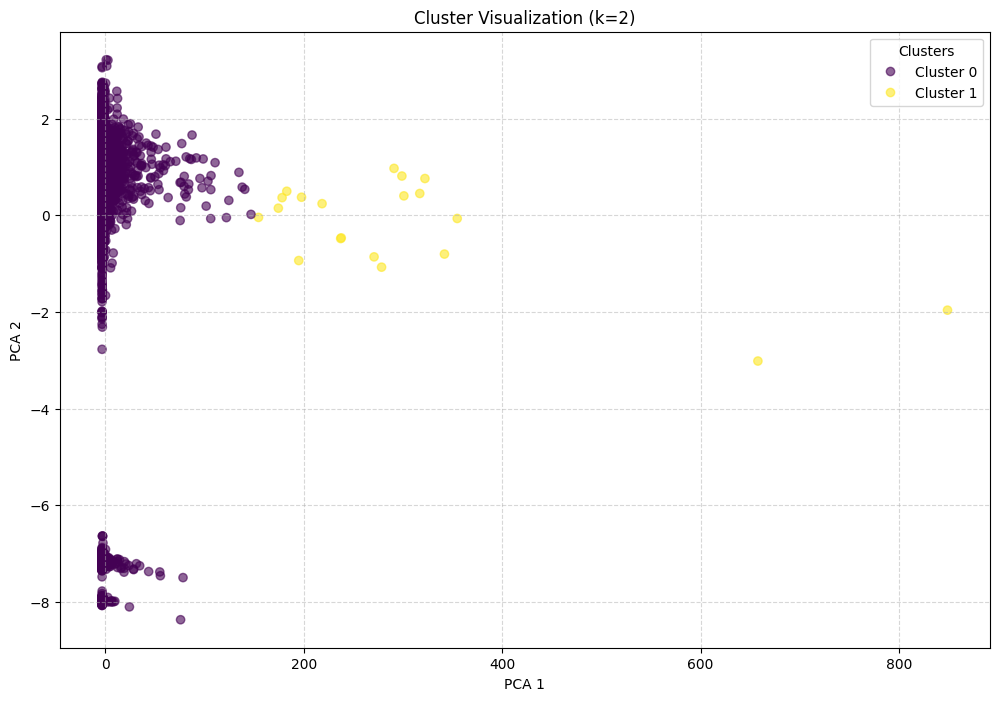

In [ ]:
# Evaluate clustering performance
def evaluate_clustering(features, labels):
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        print("\nNot enough clusters to evaluate.")
        silhouette_avg = "N/A"
        davies_score = "N/A"
        try:
            calinski_score = calinski_harabasz_score(features, labels)
        except ValueError:
            calinski_score = "N/A"
    else:
        silhouette_avg = silhouette_score(features, labels)
        calinski_score = calinski_harabasz_score(features, labels)
        davies_score = davies_bouldin_score(features, labels)

    print("\nClustering Metrics:")
    print(f"  Clusters: {n_clusters}")
    print(f"  Silhouette: {silhouette_avg:.3f}" if isinstance(silhouette_avg, (int, float)) else f"  Silhouette: {silhouette_avg}")
    print(f"  Calinski-Harabasz: {calinski_score:.3f}" if isinstance(calinski_score, (int, float)) else f"  Calinski-Harabasz: {calinski_score}")
    print(f"  Davies-Bouldin: {davies_score:.3f}" if isinstance(davies_score, (int, float)) else f"  Davies-Bouldin: {davies_score}")

    # Print cluster sizes
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        percentage = (size / len(df)) * 100
        print(f"  Cluster {cluster}: {size} items ({percentage:.1f}%)")

# Run evaluation
if clustering_features_scaled is not None and 'cluster' in df.columns:
    evaluate_clustering(clustering_features_scaled, df['cluster'])
else:
    print("Skipping evaluation.")

# Visualize clusters
def visualize_clusters(features, labels):
    """
    PCA-based 2D cluster plot
    """
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        print("\nNot enough clusters to visualize.")
        return

    pca = PCA(n_components=2)
    coords = pca.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(coords[:, 0], coords[:, 1],
                          c=labels,
                          cmap='viridis',
                          alpha=0.6)

    legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Clusters")
    plt.title(f'Cluster Visualization (k={n_clusters})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Show visualization
if clustering_features_scaled is not None and 'cluster' in df.columns:
    visualize_clusters(clustering_features_scaled, df['cluster'])
else:
    print("Skipping visualization.")


#### Penjelasan Kode:
1.  **Fungsi `recommend`**:
    *   Menerima judul buku sebagai input.
    *   Mencari judul yang paling mirip dalam data menggunakan `difflib`.
    *   Mengambil skor kemiripan (cosine similarity) buku yang cocok tersebut terhadap semua buku lain dari matriks `similarity`.
    *   Mengurutkan buku berdasarkan skor kemiripan tertinggi.
    *   Mengembalikan 5 buku teratas (tidak termasuk buku input itu sendiri).
2.  **Fungsi Evaluasi**:
    *   `evaluate_recommendations`: Menjalankan fungsi `recommend` untuk setiap buku dalam daftar `test_books` dan memanggil fungsi evaluasi lainnya.
    *   `display_recommendations`: Menampilkan detail 5 rekomendasi teratas (judul, penulis, kategori, tahun, skor kemiripan).
    *   `analyze_similarity_scores`: Menghitung rata-rata & skor kemiripan tertinggi *dari rekomendasi terhadap buku input*.
    *   `evaluate_diversity`: Menghitung rata-rata kemiripan *antar buku dalam daftar rekomendasi* (Intra-List Similarity) untuk mengukur keberagaman. Memberi tanda (✅/⚠️) berdasarkan skor ini.
3.  **Eksekusi**: Kode mendefinisikan daftar `test_books` dan menjalankan `evaluate_recommendations` untuk mengevaluasi & menampilkan hasil rekomendasi untuk setiap buku dalam daftar tersebut.

---

#### Penjelasan Hasil Output:
Output menunjukkan hasil evaluasi rekomendasi untuk 5 buku uji:
*   Untuk **setiap buku uji**:
    *   Menampilkan judul input dan judul paling mirip yang ditemukan.
    *   Menampilkan **5 rekomendasi teratas** beserta detail (judul, penulis, dll.) dan **skor kemiripannya** dengan buku input.
    *   Menampilkan **rata-rata & skor tertinggi** kemiripan rekomendasi terhadap input.
    *   Menampilkan **rata-rata kemiripan antar rekomendasi** (Intra-List Similarity) dan memberikan penilaian keberagaman (✅=baik).
*   **Secara keseluruhan**: Output mendemonstrasikan kemampuan model untuk menemukan kecocokan judul, memberikan rekomendasi yang relevan (berdasarkan skor similarity), dan menunjukkan bahwa rekomendasi yang dihasilkan cenderung **beragam** (skor intra-list rendah, ditandai ✅) untuk semua buku uji.

In [ ]:
# Function to Display Sample Representatives from Each Cluster
def display_cluster_samples(df, num_samples=3):
    print("\n Sample Books Representing Each Cluster ")

    if 'cluster' not in df.columns:
        print("Error: 'cluster' column not found in DataFrame.")
        return

    # Ensure cluster labels are sorted for consistent output (Cluster 1, Cluster 2)
    unique_cluster_labels = sorted(df['cluster'].unique())

    for cluster_label in unique_cluster_labels:
        # Filter the DataFrame for the current cluster
        cluster_df = df[df['cluster'] == cluster_label].copy()

        # Determine how many samples to show (handle small clusters)
        n_to_sample = min(num_samples, len(cluster_df))

        # Display cluster header (using Cluster 1, Cluster 2 naming)
        print(f"\n Cluster {cluster_label + 1} (Showing {n_to_sample} samples) ")

        if n_to_sample == 0:
            print("  No books found in this cluster.")
            continue

        # Get random samples
        # Use a fixed random_state if you want the same samples each time you run
        samples = cluster_df.sample(n=n_to_sample, random_state=42)

        # Display details for each sample book
        for index, book_info in samples.iterrows():
            print(f"  - Title: {book_info['title']}")
            print(f"    Authors: {book_info['authors']}")
            print(f"    Categories: {book_info['categories']}")
            print(f"    Published Year: {book_info['published_year']}")
            print(f"    Average Rating: {book_info['average_rating']:.1f}")
            print(f"    Pages: {book_info['num_pages']}")
            print(f"    Ratings Count: {book_info['ratings_count']}")
            print("-" * 20) # Separator between books

    print("\n End of Sample Display ")


# Show Sample Representatives
display_cluster_samples(df, num_samples=3)


 Sample Books Representing Each Cluster 

 Cluster 1 (Showing 3 samples) 
  - Title: krakatoa
    Authors: simon winchester
    Categories: history
    Published Year: 2005
    Average Rating: 387.0
    Pages: 464
    Ratings Count: 14491
--------------------
  - Title: the people of sparks
    Authors: jeanne duprau
    Categories: juvenile fiction
    Published Year: 2005
    Average Rating: 366.0
    Pages: 338
    Ratings Count: 44751
--------------------
  - Title: the white house
    Authors: debra hess
    Categories: history
    Published Year: 2003
    Average Rating: 4.0
    Pages: 40
    Ratings Count: 3
--------------------

 Cluster 2 (Showing 3 samples) 
  - Title: harry potter and the sorcerers stone book 1
    Authors: rowling jk
    Categories: juvenile fiction
    Published Year: 2015
    Average Rating: 447.0
    Pages: 320
    Ratings Count: 5629932
--------------------
  - Title: water for elephants
    Authors: sara gruen
    Categories: fiction
    Published Yea

#### Penjelasan Kode:
1.  **Fungsi `evaluate_clustering`**:
    *   Menghitung metrik evaluasi clustering:
        *   **Silhouette Score**: Mengukur seberapa mirip objek dengan clusternya sendiri dibandingkan cluster lain (nilai lebih tinggi, mendekati 1, lebih baik).
        *   **Calinski-Harabasz Index**: Rasio antara varians antar-cluster dan varians intra-cluster (nilai lebih tinggi lebih baik).
        *   **Davies-Bouldin Index**: Rata-rata kemiripan antar cluster (nilai lebih rendah lebih baik).
    *   Menghitung dan menampilkan ukuran (jumlah item & persentase) untuk setiap cluster.
2.  **Fungsi `visualize_clusters`**:
    *   Menggunakan **PCA (Principal Component Analysis)** untuk mengurangi dimensi fitur menjadi 2D agar bisa divisualisasikan.
    *   Membuat **scatter plot** dari data yang sudah direduksi dimensinya.
    *   Memberi **warna** pada titik data sesuai dengan label clusternya.
    *   Menampilkan legenda, judul, dan grid pada plot.
3.  **Eksekusi**: Kode memanggil kedua fungsi di atas untuk mengevaluasi performa clustering dengan k=2 dan menampilkannya secara visual.

---

#### Penjelasan Hasil Output:
*   **Metrik Clustering**:
    *   Menunjukkan hasil clustering dengan **2 cluster**.
    *   **Silhouette (0.976)**: Sangat tinggi, mengindikasikan pemisahan antar cluster yang sangat baik dan kepadatan dalam cluster yang baik.
    *   **Calinski-Harabasz (10063.465)**: Sangat tinggi, mendukung adanya struktur cluster yang jelas.
    *   **Davies-Bouldin (0.353)**: Relatif rendah, juga menunjukkan pemisahan cluster yang baik.
*   **Ukuran Cluster**:
    *   Terjadi **ketidakseimbangan ukuran yang ekstrim**: Cluster 0 berisi hampir semua data (99.7%), sedangkan Cluster 1 sangat kecil (0.3%).

---

#### Penjelasan Visual (Grafik):
*   Grafik menampilkan **visualisasi 2D (hasil PCA)** dari dua cluster yang terbentuk.
*   **Cluster 0 (Ungu Tua)**: Terlihat sebagai kelompok **besar dan padat** di sisi kiri plot.
*   **Cluster 1 (Kuning Terang)**: Terlihat sebagai kelompok **kecil dan tersebar** di sisi kanan plot.
*   **Kesimpulan Visual**: Plot secara visual **mengonfirmasi pemisahan yang jelas** antara dua cluster, namun juga menegaskan **ketidakseimbangan ukuran** yang signifikan seperti yang ditunjukkan oleh output numerik.

### Evaluation for Hybrid Recommendation

In [ ]:
def analyze_cbf_scores(recommendations_data):
    if not recommendations_data:
        print("  No recommendations to analyze scores for.")
        return

    scores = [score for _, score in recommendations_data]
    avg_similarity = np.mean(scores)
    max_similarity = np.max(scores)

    print(f"  Average CBF Similarity Score: {avg_similarity:.3f}")
    print(f"  Highest CBF Similarity Score: {max_similarity:.3f}")

def calculate_cbf_diversity(recommendations_data, feature_vectors):
    """Calculates and prints CBF intra-list similarity (lower is more diverse)."""
    # recommendations_data is a list of tuples: (index, score)
    if len(recommendations_data) < 2:
        print("  Not enough recommendations to calculate diversity.")
        return 0.0 # Or handle as appropriate

    rec_indices = [index for index, _ in recommendations_data]
    rec_vectors = feature_vectors[rec_indices]

    # Calculate pairwise similarity within the recommendation list
    intra_list_similarity_matrix = cosine_similarity(rec_vectors)

    # Summing upper triangle (excluding diagonal) and dividing by number of pairs
    n = len(rec_indices)
    upper_triangle_sum = np.triu(intra_list_similarity_matrix, k=1).sum()
    num_pairs = n * (n - 1) / 2
    avg_intra_list_similarity = upper_triangle_sum / num_pairs if num_pairs > 0 else 0

    print(f"  CBF Intra-List Similarity (Diversity Metric): {avg_intra_list_similarity:.3f} (Lower is more diverse)")
    return avg_intra_list_similarity

def analyze_cluster_alignment(input_cluster_label, recommendations_data, df):
    """Analyzes how many recommendations are in the same cluster as the input."""
    # recommendations_data is a list of tuples: (index, score)
    if not recommendations_data:
        print("  No recommendations to analyze cluster alignment for.")
        return

    same_cluster_count = 0
    total_recs = len(recommendations_data)

    for index, _ in recommendations_data:
        rec_cluster_label = df.loc[index, 'cluster']
        if rec_cluster_label == input_cluster_label:
            same_cluster_count += 1

    diff_cluster_count = total_recs - same_cluster_count
    same_cluster_percent = (same_cluster_count / total_recs) * 100 if total_recs > 0 else 0

    print(f"  Cluster Alignment:")
    print(f"    - Input Book Cluster: {input_cluster_label}")
    print(f"    - Recommendations in same cluster: {same_cluster_count}/{total_recs} ({same_cluster_percent:.1f}%)")
    print(f"    - Recommendations in different clusters: {diff_cluster_count}/{total_recs}")


# Main Combined Evaluation Function
def evaluate_combined_recommendations(book_name, df, similarity_matrix, feature_vectors, n_recommendations=5):

    print(f" Evaluating Recommendations for: '{book_name}' ")

    # Find the closest match for the input book title
    matches = difflib.get_close_matches(book_name, list_of_all_titles, n=1, cutoff=0.6)
    if not matches:
        print("  Book not found in dataset.\n")
        return

    close_match = matches[0]
    print(f"  Closest match found: '{close_match}'")

    try:
        # Get the index and cluster label of the input book
        index_of_the_book = df[df.title == close_match].index[0]
        input_cluster_label = df.loc[index_of_the_book, 'cluster']

        # Get similarity scores for the input book
        similarity_scores = list(enumerate(similarity_matrix[index_of_the_book]))

        # Sort books based on similarity (descending)
        sorted_similar_books = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

        # recommendations_data contains tuples of (index, similarity_score)
        recommendations_data = sorted_similar_books[1 : n_recommendations + 1]

        if not recommendations_data:
             print("  No similar books found for recommendation.")
             print("-" * 40 + "\n")
             return

        print(f"\n  Top {len(recommendations_data)} CBF Recommendations & Cluster Info:")
        for i, (rec_index, score) in enumerate(recommendations_data):
            rec_title = df.loc[rec_index, 'title']
            rec_cluster = df.loc[rec_index, 'cluster']
            print(f"    {i+1}. Title: {rec_title} (Cluster: {rec_cluster}, CBF Score: {score:.3f})")

        # Evaluation Metrics
        print("\n  Evaluation:")
        # CBF Quality/Relevance
        analyze_cbf_scores(recommendations_data)

        # CBF Diversity
        calculate_cbf_diversity(recommendations_data, feature_vectors)

        # Cluster Alignment
        analyze_cluster_alignment(input_cluster_label, recommendations_data, df)

    except IndexError:
         print(f"  Error processing book: '{close_match}'. Index might be out of bounds.")
    except Exception as e:
        print(f"  An unexpected error occurred for '{close_match}': {e}")

    print("-" * 40 + "\n")


#  Run Evaluation on Test Books
test_books = ["habbit", "gilead", "fahrenheit 451", "the hobbit or there and back again"]

for book in test_books:
    evaluate_combined_recommendations(book, df, similarity, feature_vectors, n_recommendations=5)

 Evaluating Recommendations for: 'habbit' 
  Closest match found: 'babbitt'

  Top 5 CBF Recommendations & Cluster Info:
    1. Title: arrowsmith (Cluster: 0, CBF Score: 0.634)
    2. Title: main street (Cluster: 0, CBF Score: 0.563)
    3. Title: cs lewis (Cluster: 0, CBF Score: 0.451)
    4. Title: the complete c s lewis signature classics (Cluster: 0, CBF Score: 0.380)
    5. Title: pink box (Cluster: 0, CBF Score: 0.369)

  Evaluation:
  Average CBF Similarity Score: 0.479
  Highest CBF Similarity Score: 0.634
  CBF Intra-List Similarity (Diversity Metric): 0.359 (Lower is more diverse)
  Cluster Alignment:
    - Input Book Cluster: 0
    - Recommendations in same cluster: 5/5 (100.0%)
    - Recommendations in different clusters: 0/5
----------------------------------------

 Evaluating Recommendations for: 'gilead' 
  Closest match found: 'gilead'

  Top 5 CBF Recommendations & Cluster Info:
    1. Title: the martians (Cluster: 0, CBF Score: 0.321)
    2. Title: robinson crusoe (C

#### Penjelasan Kode:
1.  **Fungsi Pembantu Evaluasi:**
    *   `analyze_cbf_scores`: Menghitung rata-rata & skor kemiripan (CBF) tertinggi dari rekomendasi *terhadap buku input*.
    *   `calculate_cbf_diversity`: Menghitung rata-rata kemiripan *antar rekomendasi* (Intra-List Similarity) untuk mengukur keberagaman (nilai lebih rendah lebih beragam).
    *   `analyze_cluster_alignment`: Membandingkan label cluster buku input dengan label cluster buku-buku rekomendasi, lalu menghitung persentasenya.
2.  **Fungsi Utama `evaluate_combined_recommendations`**:
    *   Menerima judul buku input.
    *   Mencari judul paling mirip di data.
    *   Mendapatkan **indeks** dan **label cluster** buku input.
    *   Mengambil **Top 5 rekomendasi CBF** (berdasarkan `similarity_matrix`).
    *   Menampilkan **detail rekomendasi** (Judul, **Cluster**, Skor CBF).
    *   Memanggil **ketiga fungsi pembantu evaluasi** (`analyze_cbf_scores`, `calculate_cbf_diversity`, `analyze_cluster_alignment`).
3.  **Eksekusi**: Kode menjalankan `evaluate_combined_recommendations` untuk setiap buku dalam daftar `test_books`.

---

#### Penjelasan Hasil Output:
Output menunjukkan hasil evaluasi gabungan untuk 4 buku uji:
*   Untuk **setiap buku uji**:
    *   Menampilkan judul input dan kecocokan terdekat yang ditemukan.
    *   Menampilkan **5 rekomendasi teratas** beserta **label cluster** masing-masing dan **skor kemiripan CBF**-nya.
    *   Menampilkan **evaluasi CBF**: Skor rata-rata/tertinggi (relevansi) dan Intra-List Similarity (keberagaman).
    *   Menampilkan **evaluasi Keselarasan Cluster**: Persentase rekomendasi yang berasal dari cluster yang sama dengan buku input.
*   **Contoh Interpretasi**:
    *   Untuk "habbit" (match: 'babbitt', Cluster 0): Semua 5 rekomendasi berasal dari Cluster 0 (100% selaras).
    *   Untuk "gilead" (Cluster 0): Semua 5 rekomendasi berasal dari Cluster 0 (100% selaras).
    *   Untuk "fahrenheit 451" (Cluster 0): Semua 5 rekomendasi berasal dari Cluster 0 (100% selaras).
    *   Untuk "the hobbit or there and back again" (Cluster 1): **Tidak ada** rekomendasi (0%) yang berasal dari Cluster 1, semuanya dari Cluster 0.
*   **Kesimpulan**: Output ini menunjukkan tidak hanya kualitas rekomendasi CBF (relevansi & keberagaman) tetapi juga **bagaimana rekomendasi tersebut tersebar di antara cluster yang ada**, memberikan wawasan tambahan tentang struktur data dan perilaku model rekomendasi. Terlihat bahwa untuk buku di Cluster 1, rekomendasi CBF cenderung berasal dari Cluster 0 yang dominan.

### Interpretasi

#### 2 Cluster

In [ ]:
# Function to Recommend with Cluster Info
def recommend_with_cluster_info(book_name):
    matches = difflib.get_close_matches(book_name, list_of_all_titles, n=1, cutoff=0.6)
    if not matches:
        print(f"Book '{book_name}' not found or no close match in the dataset. Please check the spelling.")
        return

    close_match = matches[0]
    print(f"\nYou searched for: '{book_name}'")
    print(f"Closest match found: '{close_match}'")

    try:
        index_of_the_book = df[df.title == close_match].index[0]
        input_cluster_label = df.loc[index_of_the_book, 'cluster']

        if input_cluster_label == 0:
            input_cluster_interpretation = "Underrated"
        elif input_cluster_label == 1:
            input_cluster_interpretation = "Best Seller / Popular"
        else:
            input_cluster_interpretation = f"Unknown Cluster ({input_cluster_label})"

        print(f"(Input book belongs to Cluster {input_cluster_label}: {input_cluster_interpretation})\n")

        similarity_scores = list(enumerate(similarity[index_of_the_book]))
        sorted_similar_books = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

        try:
            n_recommendations = int(input("Enter the number of Content-Based recommendations desired: "))
            if n_recommendations < 1:
                raise ValueError("Number must be at least 1")
        except ValueError as e:
            print(f"Invalid input: {e}")
            return

        cbf_recommendations_data = sorted_similar_books[1 : n_recommendations + 1]

        if not cbf_recommendations_data:
             print("No other similar books found for Content-Based recommendation.")
        else:
            print(f"\n Top {len(cbf_recommendations_data)} Content-Based Recommendations (Most Similar Content) ")
            for i, (rec_index, score) in enumerate(cbf_recommendations_data):
                book_info = df.loc[rec_index, [
                    'title', 'authors', 'categories', 'published_year',
                    'average_rating', 'num_pages', 'ratings_count', 'cluster'
                ]]
                rec_cluster_label = book_info['cluster']
                if rec_cluster_label == 0:
                    cluster_type = "Underrated"
                elif rec_cluster_label == 1:
                    cluster_type = "Best Seller / Popular"
                else:
                    cluster_type = f"Unknown Cluster ({rec_cluster_label})"

                print(f"{i+1}. Title: {book_info['title']}")
                print(f"   Authors: {book_info['authors']}")
                print(f"   Categories: {book_info['categories']}")
                print(f"   Published Year: {book_info['published_year']}")
                print(f"   Average Rating: {book_info['average_rating']:.1f}")
                print(f"   Pages: {book_info['num_pages']}")
                print(f"   Ratings Count: {book_info['ratings_count']}")
                print(f"   Popularity: {cluster_type} (Cluster {rec_cluster_label})")
                print(f"   Content Similarity: {score:.3f}\n")

        print("-" * 40)
        print("\nMost Similar Popular Books (Based on Content Similarity & Cluster 1) ")

        popular_book_indices = df[df['cluster'] == 1].index
        popular_similarity_scores = []
        for idx, score in similarity_scores:
            if idx != index_of_the_book and idx in popular_book_indices:
                popular_similarity_scores.append((idx, score))

        sorted_popular_similar = sorted(popular_similarity_scores, key=lambda x: x[1], reverse=True)

        n_popular_recs = min(3, len(sorted_popular_similar))
        if n_popular_recs > 0:
            print(f"(Showing top {n_popular_recs} most similar books from the 'Best Seller' segment)")
            for i, (rec_index, score) in enumerate(sorted_popular_similar[:n_popular_recs]):
                book_info = df.loc[rec_index, [
                    'title', 'authors', 'categories', 'published_year',
                    'average_rating', 'num_pages', 'ratings_count', 'cluster'
                ]]

                print(f"{i+1}. Title: {book_info['title']}")
                print(f"   Authors: {book_info['authors']}")
                print(f"   Categories: {book_info['categories']}")
                print(f"   Published Year: {book_info['published_year']}")
                print(f"   Pages: {book_info['num_pages']}")
                print(f"   Average Rating: {book_info['average_rating']:.1f}")
                print(f"   Ratings Count: {book_info['ratings_count']}")
                print(f"   Content Similarity: {score:.3f}\n")
        else:
            print("No similar popular books found in Cluster 1.")
        print("-" * 40 + "\n")


    except IndexError:
         print(f"Error processing book: '{close_match}'. Index might be out of bounds.")
    except Exception as e:
        print(f"An unexpected error occurred for '{close_match}': {e}")

# Execution part
if 'df' in locals() and 'cluster' in df.columns and 'list_of_all_titles' in locals() and 'similarity' in locals():
    book_title_input = input("Enter the title of your favorite book: ")
    recommend_with_cluster_info(book_title_input)
else:
    print("Error: Necessary data (DataFrame with 'cluster' column, list_of_all_titles, similarity matrix) not available. Please run the preceding cells.")

Enter the title of your favorite book: bali

You searched for: 'bali'
Closest match found: 'bliss'
(Input book belongs to Cluster 0: Underrated)

Enter the number of Content-Based recommendations desired: 5

 Top 5 Content-Based Recommendations (Most Similar Content) 
1. Title: the chase
   Authors: lynsay sands
   Categories: fiction
   Published Year: 2004
   Average Rating: 405.0
   Pages: 374
   Ratings Count: 2011
   Popularity: Underrated (Cluster 0)
   Content Similarity: 0.651

2. Title: the deed
   Authors: lynsay sands
   Categories: fiction
   Published Year: 2004
   Average Rating: 393.0
   Pages: 313
   Ratings Count: 2937
   Popularity: Underrated (Cluster 0)
   Content Similarity: 0.644

3. Title: love bites
   Authors: lynsay sands
   Categories: fiction
   Published Year: 2003
   Average Rating: 412.0
   Pages: 373
   Ratings Count: 18316
   Popularity: Underrated (Cluster 0)
   Content Similarity: 0.624

4. Title: love is blind
   Authors: lynsay sands
   Categories: 

#### Penjelasan Kode:
1.  **Fungsi `recommend_with_cluster_info`**:
    *   **Input & Kecocokan**: Menerima input judul buku, mencari kecocokan terdekat dalam data menggunakan `difflib`.
    *   **Info Buku Input**: Mendapatkan indeks dan label cluster buku yang cocok. Memberikan interpretasi label cluster (misal, Cluster 0 = "Underrated", Cluster 1 = "Best Seller / Popular").
    *   **Rekomendasi Berbasis Konten (CBF)**:
        *   Mendapatkan skor kemiripan (cosine similarity) buku input terhadap semua buku lain.
        *   Mengurutkan berdasarkan kemiripan tertinggi.
        *   Meminta pengguna memasukkan jumlah rekomendasi CBF yang diinginkan.
        *   Menampilkan N rekomendasi teratas (berdasarkan kemiripan konten) beserta **detail lengkap** (penulis, kategori, tahun, rating, halaman, jumlah rating, **label cluster & interpretasinya**, dan **skor kemiripan konten**).
    *   **Rekomendasi Buku Populer (Filter Cluster 1)**:
        *   Mengidentifikasi *semua* buku yang termasuk dalam Cluster 1 ("Best Seller / Popular").
        *   Memfilter buku-buku populer ini berdasarkan **kemiripan kontennya** dengan *buku input*.
        *   Mengurutkan buku populer yang relevan ini berdasarkan skor kemiripan konten tertinggi.
        *   Menampilkan **Top 3** (atau kurang) buku populer yang paling mirip secara konten dengan buku input, beserta detailnya (tanpa info cluster, karena sudah pasti Cluster 1).
    *   **Error Handling**: Menangani jika buku tidak ditemukan atau terjadi error lain.
2.  **Eksekusi**: Meminta input judul buku dari pengguna dan menjalankan fungsi `recommend_with_cluster_info`.

---

#### Penjelasan Hasil Output:
*   **Input & Kecocokan**: Pengguna memasukkan "bali", kecocokan terdekat yang ditemukan adalah "bliss".
*   **Cluster Buku Input**: Buku "bliss" termasuk dalam **Cluster 0 ("Underrated")**.
*   **Rekomendasi CBF (n=5)**:
    *   Menampilkan **5 buku** yang kontennya paling mirip dengan "bliss".
    *   Semua **5 rekomendasi ini juga berasal dari Cluster 0 ("Underrated")**, dengan skor kemiripan konten berkisar dari **0.651 hingga 0.577**.
*   **Rekomendasi Populer (Cluster 1)**:
    *   Menampilkan **Top 3 buku dari Cluster 1 ("Best Seller")** yang kontennya *paling mirip* (meskipun jauh lebih rendah kemiripannya dibandingkan rekomendasi CBF) dengan "bliss".
    *   Buku-buku ini (misalnya "the alchemist", "the giver") memiliki skor kemiripan konten sekitar **0.15**.
*   **Kesimpulan Output**: Model berhasil memberikan dua jenis rekomendasi: (1) Buku yang **sangat mirip secara konten** (kebetulan berasal dari cluster yang sama dengan input), dan (2) Buku **populer (dari Cluster 1)** yang masih memiliki *sedikit* kemiripan konten dengan buku input. Ini memberikan pengguna pilihan antara buku yang sangat relevan secara tema/konten dan buku populer yang mungkin menarik minatnya.

## Kesimpulan

Proyek ini berhasil mengimplementasikan sebuah **Sistem Rekomendasi Buku Berbasis Konten (Content-Based Filtering)** yang fungsional.

**Hasil Akhir Utama:**

*   **Rekomendasi Berdasarkan Kemiripan Konten:** Sistem mampu merekomendasikan buku kepada pengguna berdasarkan kemiripan **konten** (judul, penulis, kategori, tahun terbit) dengan buku yang mereka sukai.
*   **Proses Inti:** Menggunakan **TF-IDF** untuk mengubah deskripsi konten buku menjadi vektor numerik dan **Cosine Similarity** untuk mengukur seberapa mirip vektor-vektor tersebut.
*   **Interaksi Pengguna:** Pengguna dapat **memasukkan judul buku** favorit mereka.
*   **Output Personalisasi:** Sistem menampilkan **daftar peringkat buku lain** yang paling mirip secara konten, dengan **jumlah rekomendasi yang bisa ditentukan pengguna**, serta menyajikan **detail penting** (seperti rating, jumlah halaman) untuk setiap buku yang direkomendasikan.

Secara singkat, sistem ini efektif dalam menyarankan buku baru kepada pengguna dengan menganalisis kesamaan fitur-fitur kunci dari buku yang telah mereka nikmati.